In [1]:
from __future__ import print_function, division
from sys import platform as _platform
import matplotlib

#if _platform == "linux" or _platform == "linux2":
#    matplotlib.use('Agg')
%matplotlib inline
#%pylab notebook
import matplotlib.pylab as plt
import os
import sys
import numpy as np
import random
import copy
import traceback
import operator
from collections import defaultdict
from pprint import pprint
import string
from graph_tool.all import *
import scipy.stats as stats
from IPython.display import HTML
import powerlaw
import pandas as pd
import sys
import os
lib_path = '/home/fgeigl/'
print('append', lib_path)
sys.path.append(lib_path)
import tools.mpl_tools as plt_tools
lib_path = '/home/fgeigl/navigability_of_networks'
print('append', lib_path)
sys.path.append(lib_path)
from data_io import get_network
from tools.mpl_tools import crop_pdf
# import seaborn
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rcParams['xtick.major.pad'] *= 2
matplotlib.rcParams['ytick.major.pad'] *= 2

append /home/fgeigl/
append /home/fgeigl/navigability_of_networks


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
data_dir = '/opt/datasets/'


datasets = list()
# datasets.append({'name': 'toy_example', 'directed': False})
# datasets.append({'name': 'karate'})
# datasets.append({'name': empiric_data_dir + 'karate/karate.edgelist', 'directed': False})
datasets.append({'name': data_dir + 'new_w4s/wiki4schools', 'directed': True})
datasets.append({'name': data_dir + 'milan_spiele/milan_spiele', 'directed': True})
datasets.append({'name': data_dir + 'getdigital_eu/getdigital_eu', 'directed': True})
datasets.append({'name': data_dir + 'thinkgeek/thinkgeek', 'directed': True})
datasets.append({'name': data_dir + 'bar_wiki/bar_wiki', 'directed': True})
datasets.append({'name': data_dir + 'orf_tvthek/tvthek_orf', 'directed': True})
datasets.append({'name': data_dir + 'daserste/daserste', 'directed': True})
# switch_backend('cairo')

In [3]:
def viz_net_struct(net, out_name, measure='in', med_perc=90, high_perc=99):
    print('measure:', measure)
    if measure == 'deg':
        measure = net.degree_property_map('total')
    elif measure == 'in':
        measure = net.degree_property_map('out')
    elif measure == 'out':
        measure = net.degree_property_map('in')
    m = np.array(sorted(measure.a, reverse=True))
    med_m = (100 - med_perc) / 100 * m.sum()
    high_m = (100-high_perc) / 100 * m.sum()
    m_cum = m.cumsum()
    med_perc = m[np.searchsorted(m_cum, med_m)]
    high_perc = m[np.searchsorted(m_cum, high_m)]
    
    # med_perc, high_perc = np.percentile(measure.a, [med_perc, high_perc])
    node_type = net.new_vertex_property('int')
    high_name = 'TOP'
    mid_name = 'MED'
    low_name = 'LOW'
    print('max measure:', measure.a.max())
    print('min measure:', measure.a.min())
    print(high_name, 'limit:', high_perc)
    print(mid_name, 'limit:', med_perc)
    print('categorize nodes')
    meas_type_sum = defaultdict(float)
    sites_type = defaultdict(set)
    for v, d in zip(net.vertices(), measure.a):
        if d >= high_perc:
            node_type[v] = 2
            meas_type_sum[high_name] += d
            sites_type[high_name].add(v)
        elif d >= med_perc:
            node_type[v] = 1
            meas_type_sum[mid_name] += d
            sites_type[mid_name].add(v)
        else:
            node_type[v] = 0
            meas_type_sum[low_name] += d
            sites_type[low_name].add(v)
    print('node dist')
    print(high_name, (node_type.a == 2).sum())
    print(mid_name, (node_type.a == 1).sum())
    print(low_name, (node_type.a == 0).sum())
    url_map = None
    try:
        url_map = net.vp['url']
    except:
        url_map = net.vp['NodeId']
    if url_map is not None:
        print('urls samples---------')
        for p_type, pages in sites_type.iteritems():
            print(p_type)
            for page in random.sample(pages, 10):
                print('\t', url_map[page])
        print('measure dist:')
        for key,val in meas_type_sum.iteritems():
            print(key, val)
        print('----------------------')
    else:
        print('no urls found:', net.vp.keys())
    
    struct_net = Graph(directed=True)
    struct_net.add_vertex(3)
    struct_v_names = struct_net.new_vertex_property('string')
    struct_v_names[struct_net.vertex(2)] = high_name
    struct_v_names[struct_net.vertex(1)] = mid_name
    struct_v_names[struct_net.vertex(0)] = low_name
    
    print('weight edges')
    struct_e_weights = struct_net.new_edge_property('float')
    for e in net.edges():
        src = node_type[e.source()]
        tar = node_type[e.target()]
        struct_e = struct_net.edge(src, tar)
        if struct_e is None:
            struct_e = struct_net.add_edge(src, tar)
        struct_e_weights[struct_e] += 1.
    print('draw graph')
    struct_e_weights = prop_to_size(struct_e_weights, mi=2, ma=10, log=False, power=1.)
    out_size = 800
    
    def norm(mi,ma,a):
        # a += a.min()
        return mi + (ma-mi) * ((a - a.min())/ (a.max()-a.min()))
    
    pos = sfdp_layout(struct_net)
    top_xy = (out_size/2, out_size/3)
    med_xy = (out_size/3, out_size/3*2)
    low_xy = (out_size/3*2, out_size/3*2)
    pos.set_2d_array(np.array(zip(*[low_xy, med_xy, top_xy])))
    #pos_x, pos_y = pos.get_2d_array(range(2))
    #pos_x = norm(out_size * 0.2, out_size * 0.8, pos_x)
    #pos_y = norm(out_size * 0.2, out_size * 0.8, pos_y)
    #pos.set_2d_array(np.array([pos_x, pos_y]))
    # print(pos.get_2d_array(range(2)))
    # fig, ax = plt.subplots()
    parr_dist = 40
    v_font_size = 30
    out_fname = out_name + '.pdf'
    graph_draw(struct_net, vertex_text=struct_v_names, fit_view=False, pos=pos, edge_pen_width=struct_e_weights,  
               output_size=(out_size, out_size), inline=True, vertex_font_size=v_font_size, parallel_distance=parr_dist, output=out_fname)
    crop_pdf(out_fname)
    #plt.show()
    
    bias = net.degree_property_map('total')
    # bias.a = np.log10(bias.a)
    print('weight edges')
    struct_e_weights = struct_net.new_edge_property('float')
    for e in net.edges():
        src = node_type[e.source()]
        tar = node_type[e.target()]
        struct_e = struct_net.edge(src, tar)
        struct_e_weights[struct_e] += bias[e.target()]
    print('draw biased graph')
    struct_e_weights = prop_to_size(struct_e_weights, mi=2, ma=15, log=False, power=1.)
    # fig, ax = plt.subplots()
    out_fname = out_name + '_deg_bias.pdf'
    graph_draw(struct_net, vertex_text=struct_v_names, fit_view=False, pos=pos, edge_pen_width=struct_e_weights,  
               output_size=(out_size, out_size), inline=True, vertex_font_size=v_font_size, parallel_distance=parr_dist, output=out_fname)
    crop_pdf(out_fname)
    
    bias = net.degree_property_map('total')
    bias.a = 1. / bias.a
    bias.a = bias.a * min(1. / bias.a)
    print('weight edges')
    struct_e_weights = struct_net.new_edge_property('float')
    for e in net.edges():
        src = node_type[e.source()]
        tar = node_type[e.target()]
        struct_e = struct_net.edge(src, tar)
        struct_e_weights[struct_e] += bias[e.target()]
    print('draw biased graph')
    struct_e_weights = prop_to_size(struct_e_weights, mi=2, ma=15, log=False, power=1.)
    # fig, ax = plt.subplots()
    out_fname = out_name + '_inv_deg_bias.pdf'
    graph_draw(struct_net, vertex_text=struct_v_names, fit_view=False, pos=pos, edge_pen_width=struct_e_weights,  
               output_size=(out_size, out_size), inline=True, vertex_font_size=v_font_size, parallel_distance=parr_dist, output=out_fname)
    crop_pdf(out_fname)
    
    bias = eigenvector(net)[1]
    print('weight edges')
    struct_e_weights = struct_net.new_edge_property('float')
    for e in net.edges():
        src = node_type[e.source()]
        tar = node_type[e.target()]
        struct_e = struct_net.edge(src, tar)
        struct_e_weights[struct_e] += bias[e.target()]
    print('draw biased graph')
    struct_e_weights = prop_to_size(struct_e_weights, mi=2, ma=15, log=False, power=1.)
    # fig, ax = plt.subplots()
    out_fname = out_name + '_eigv_bias.pdf'
    graph_draw(struct_net, vertex_text=struct_v_names, fit_view=False, pos=pos, edge_pen_width=struct_e_weights,  
               output_size=(out_size, out_size), inline=True, vertex_font_size=v_font_size, parallel_distance=parr_dist, output=out_fname)
    crop_pdf(out_fname)
    #plt.show()

==================================wiki4schools==================================
get network: wiki4schools


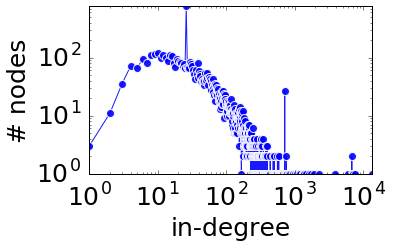

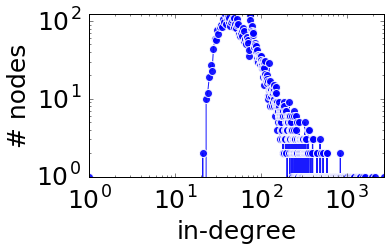

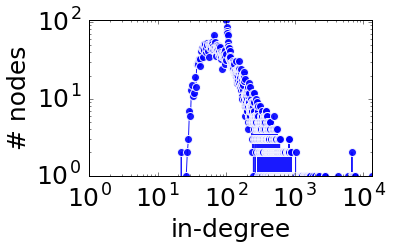

==================================milan_spiele==================================
get network: milan_spiele


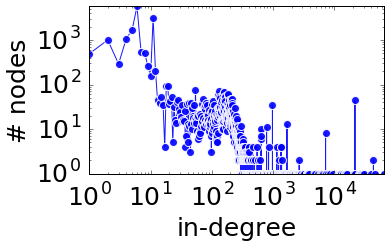

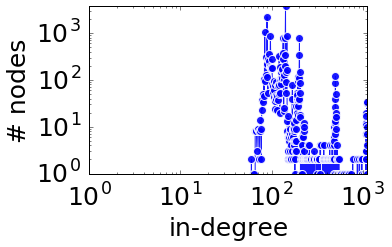

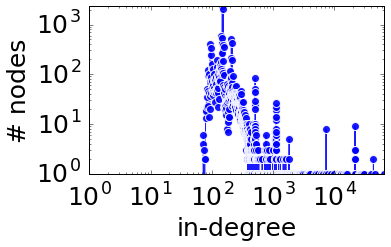

=================================getdigital_eu==================================
get network: getdigital_eu


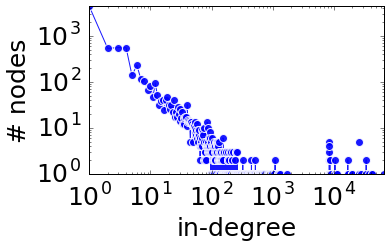

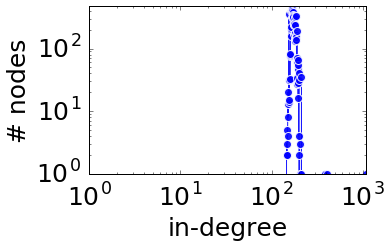

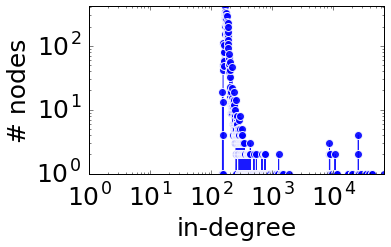

===================================thinkgeek====================================
get network: thinkgeek


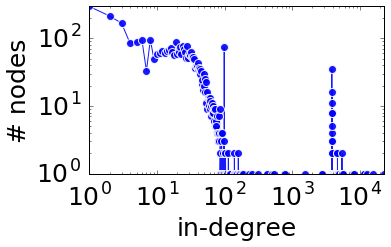

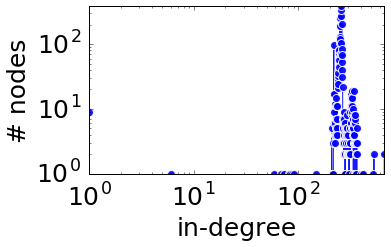

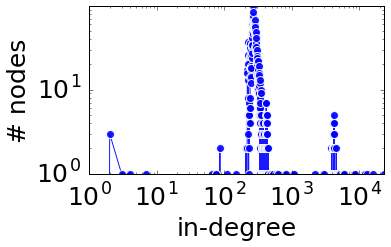

====================================bar_wiki====================================
get network: bar_wiki


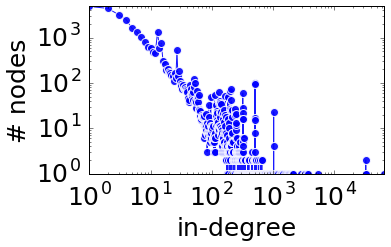

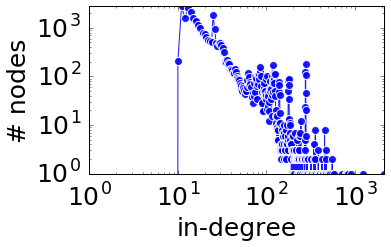

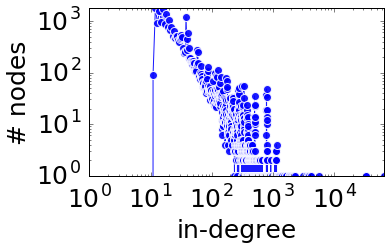

===================================tvthek_orf===================================
get network: tvthek_orf


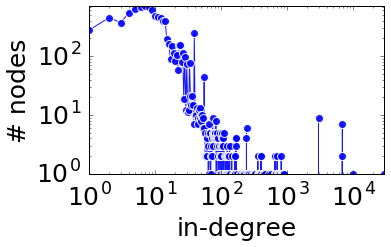

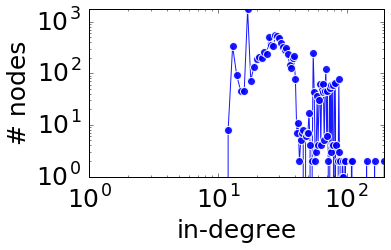

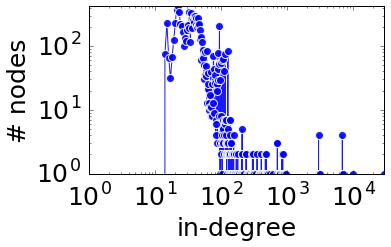

====================================daserste====================================
get network: daserste


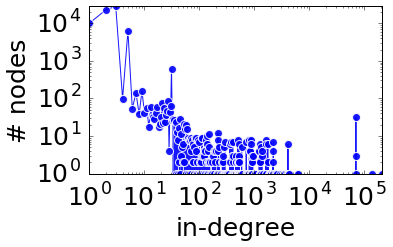

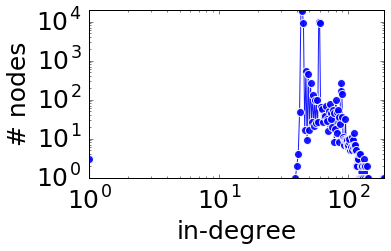

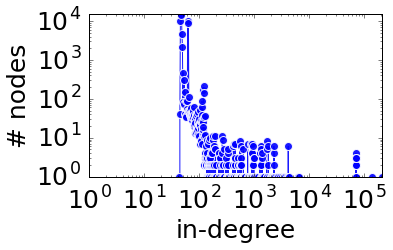

In [4]:
out_dir = 'deg_plots/'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
for ds in datasets:
    network_name = ds['name']
    ds = ds.copy()
    ds.pop("name", None)
    file_name = network_name.rsplit('/', 1)[-1]
    print(file_name.center(80, '='))
    net = get_network(network_name, **ds)
    network_name, file_name = file_name, network_name
    for deg_type in ['in', 'out', 'total']:
        counts, bins = vertex_hist(net, deg_type)
        counts = counts[1:]
        bins = bins[1:-1]
        plt.plot(bins, counts, '-o', markeredgecolor='white', markeredgewidth=1, markersize=8, alpha=0.9, lw=1)#, s=40)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim([bins[0], bins[-1]])
        plt.ylim([counts.min(), counts.max()])
        plt.xlabel('in-degree')
        plt.ylabel('# nodes')
        plt.tight_layout()
        plt.savefig(out_dir + network_name + '_' + deg_type + '.pdf')
        crop_pdf(out_dir + network_name + '_' + deg_type + '.pdf')
        plt.show()
    

==================================wiki4schools==================================
get network: wiki4schools
	 wiki4schools : 6796 v 646646 e
measure: out
max measure: 13589
min measure: 1
TOP limit: 583
MED limit: 115
categorize nodes
node dist
TOP 100
MED 1053
LOW 5643
urls samples---------
MED
	 http://schools-wikipedia.org/wp/m/Manchester_United_F.C..htm
	 http://schools-wikipedia.org/wp/1/1944.htm
	 http://schools-wikipedia.org/wp/t/Tungsten.htm
	 http://schools-wikipedia.org/wp/m/Milan.htm
	 http://schools-wikipedia.org/wp/m/Malaria.htm
	 http://schools-wikipedia.org/wp/g/Gravitation.htm
	 http://schools-wikipedia.org/wp/n/Namibia.htm
	 http://schools-wikipedia.org/wp/c/Copper.htm
	 http://schools-wikipedia.org/wp/a/Assyria.htm
	 http://schools-wikipedia.org/wp/1/1909.htm
TOP
	 http://schools-wikipedia.org/wp/s/Soviet_Union.htm
	 http://schools-wikipedia.org/wp/index/j.htm
	 http://schools-wikipedia.org/wp/index/q.htm
	 http://schools-wikipedia.org/wp/n/New_York_City.htm
	 http://s

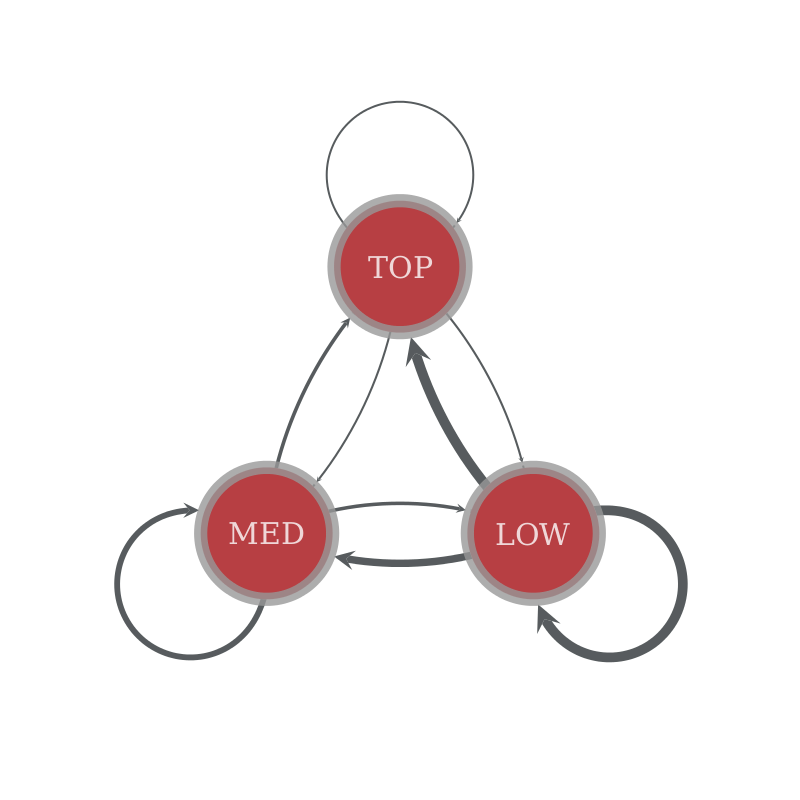

weight edges
draw biased graph


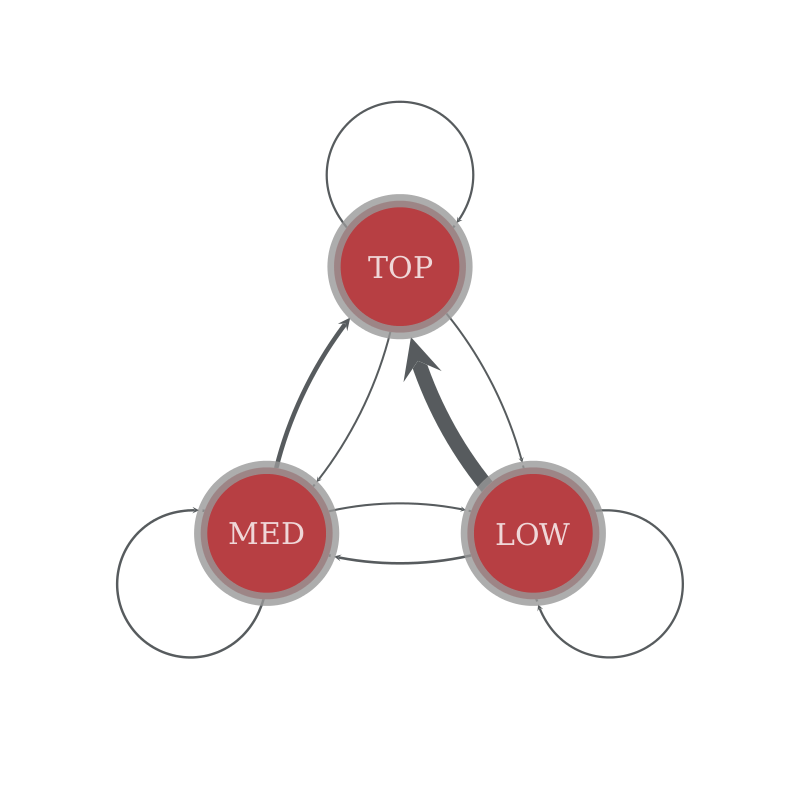

weight edges
draw biased graph


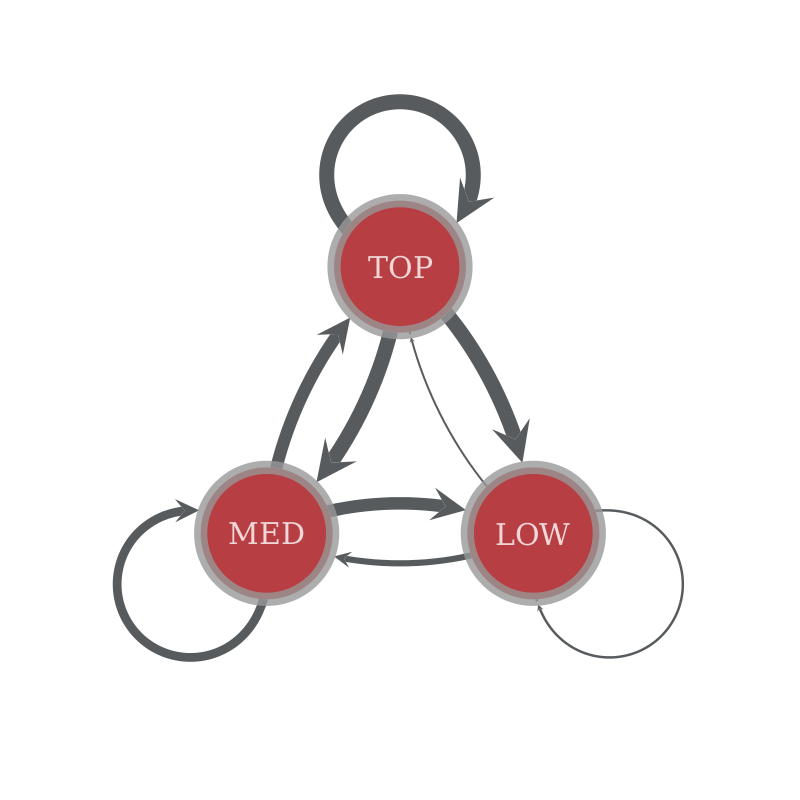

weight edges
draw biased graph


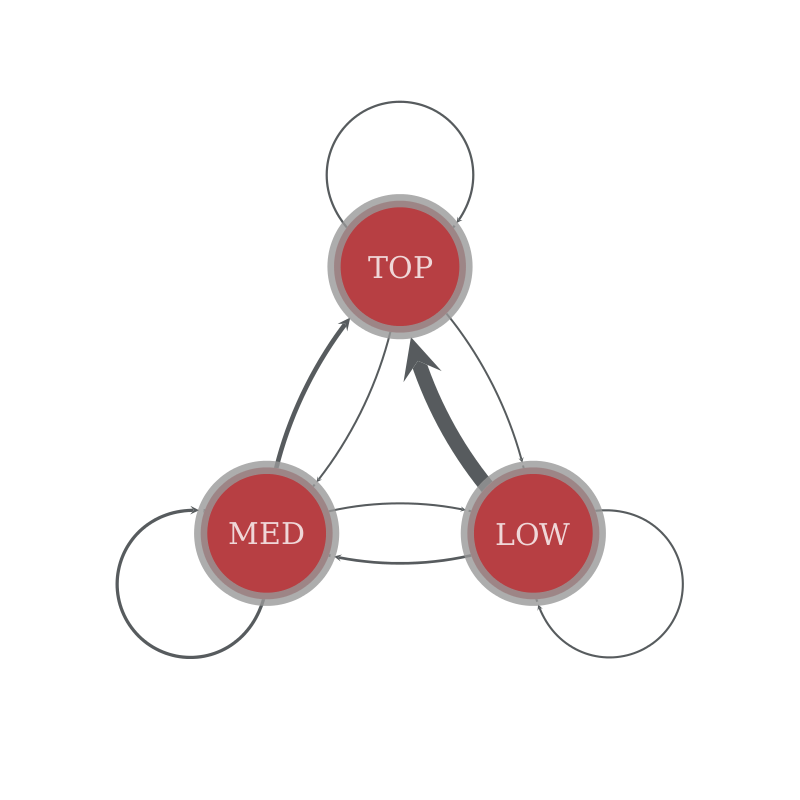

---rewired---
measure: out
max measure: 13589
min measure: 1
TOP limit: 583
MED limit: 115
categorize nodes
node dist
TOP 100
MED 1053
LOW 5643
urls samples---------
MED
	 http://schools-wikipedia.org/wp/1/1986.htm
	 http://schools-wikipedia.org/wp/m/Michael_Jackson.htm
	 http://schools-wikipedia.org/wp/w/Winston_Churchill.htm
	 http://schools-wikipedia.org/wp/l/Luxembourg.htm
	 http://schools-wikipedia.org/wp/c/Cairo.htm
	 http://schools-wikipedia.org/wp/g/George_III_of_the_United_Kingdom.htm
	 http://schools-wikipedia.org/wp/p/Polonium.htm
	 http://schools-wikipedia.org/wp/s/Stable_isotope.htm
	 http://schools-wikipedia.org/wp/f/Flerovium.htm
	 http://schools-wikipedia.org/wp/g/Greece.htm
TOP
	 http://schools-wikipedia.org/wp/index/alpha.htm
	 http://schools-wikipedia.org/wp/index/subject.Religion.htm
	 http://schools-wikipedia.org/wp/g/Germany.htm
	 http://schools-wikipedia.org/wp/index/subject.Business_Studies.htm
	 http://schools-wikipedia.org/wp/o/Ottoman_Empire.htm
	 http://scho

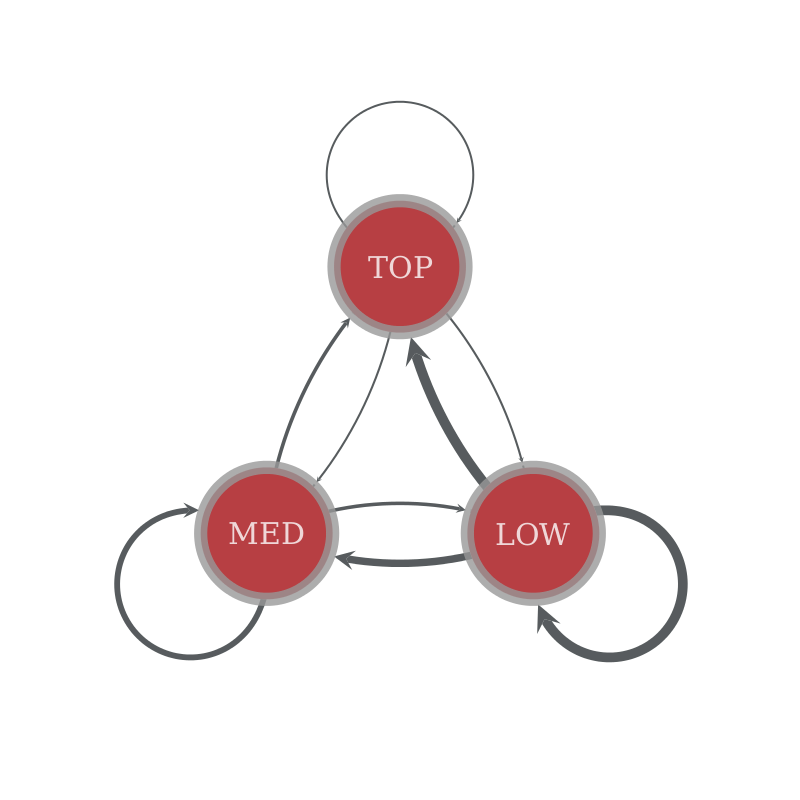

weight edges
draw biased graph


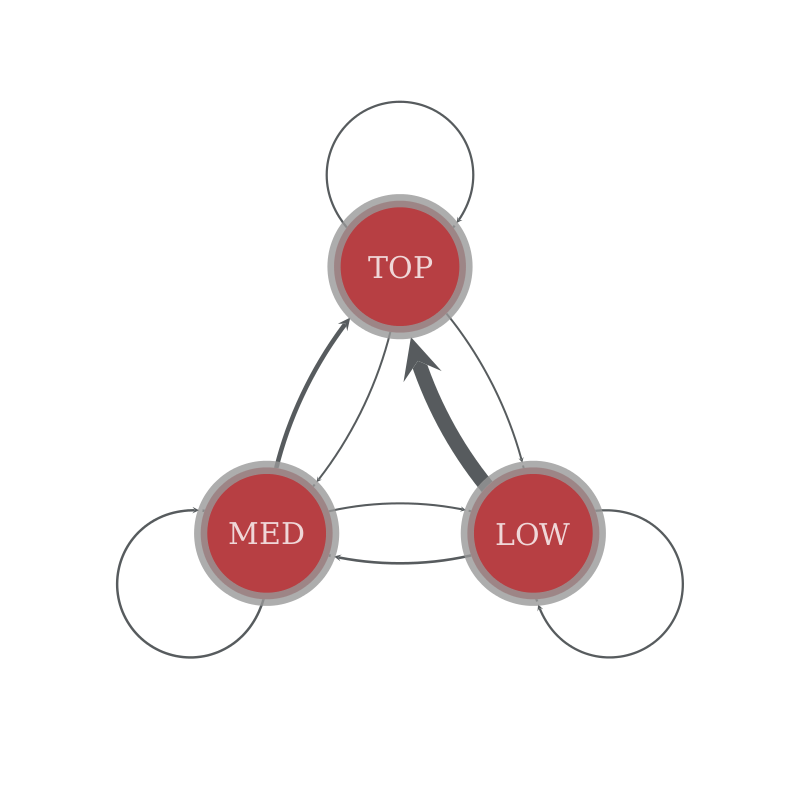

weight edges
draw biased graph


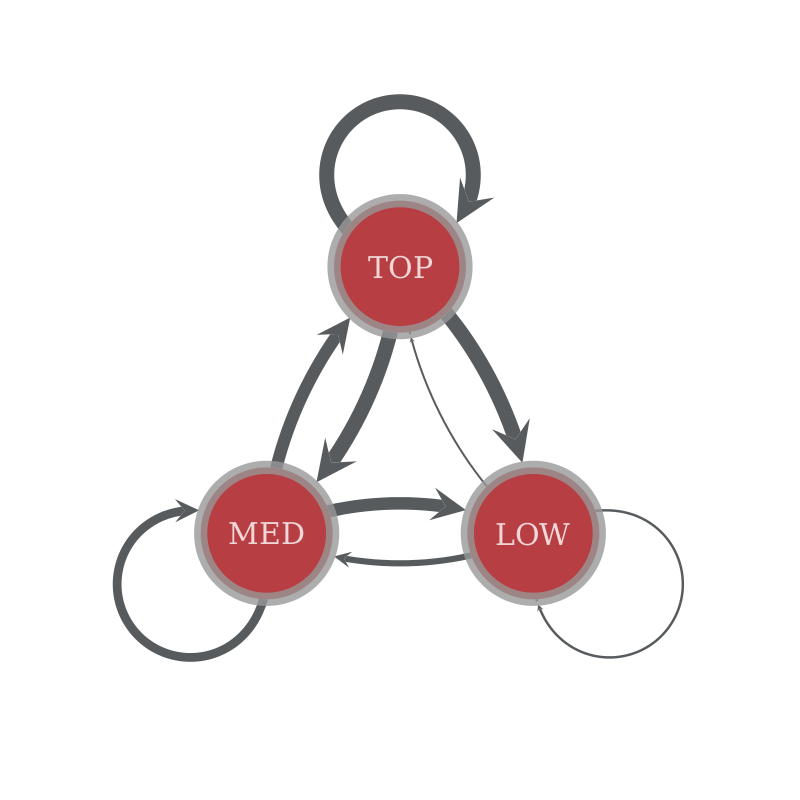

weight edges
draw biased graph


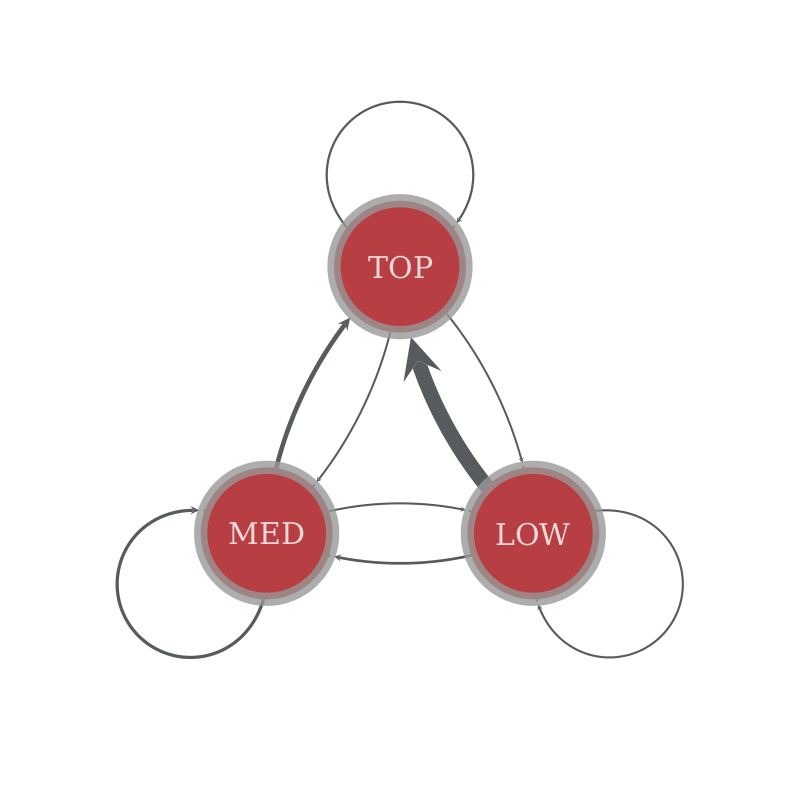

==================================milan_spiele==================================
get network: milan_spiele
	 milan_spiele : 21566 v 3128693 e
measure: out
max measure: 64695
min measure: 1
TOP limit: 21565
MED limit: 809
categorize nodes
node dist
TOP 59
MED 220
LOW 21287
urls samples---------
MED
	 http://www.milan-spiele.de/brettspiele-battles-westeros-c-82_625.html
	 http://www.milan-spiele.de/alea-spiele-m-14.html
	 http://www.milan-spiele.de/nach-anzahl-vier-spieler-c-93_97.html?perPage=25&sort=1a
	 http://www.milan-spiele.de/moses-verlag-m-162.html
	 http://www.milan-spiele.de/nach-anzahl-vier-spieler-c-93_97.html?perPage=250&sort=1a
	 http://www.milan-spiele.de/mayfair-games-m-103.html
	 http://www.milan-spiele.de/prosperity-p-16250.html
	 http://www.milan-spiele.de/concordia-britannia-p-17517.html
	 http://www.milan-spiele.de/zoch-verlag-m-74.html
	 http://www.milan-spiele.de/king-tokyo-promokarten-p-18084.html
TOP
	 http://www.milan-spiele.de/angebote-c-103.html
	 http://www.m

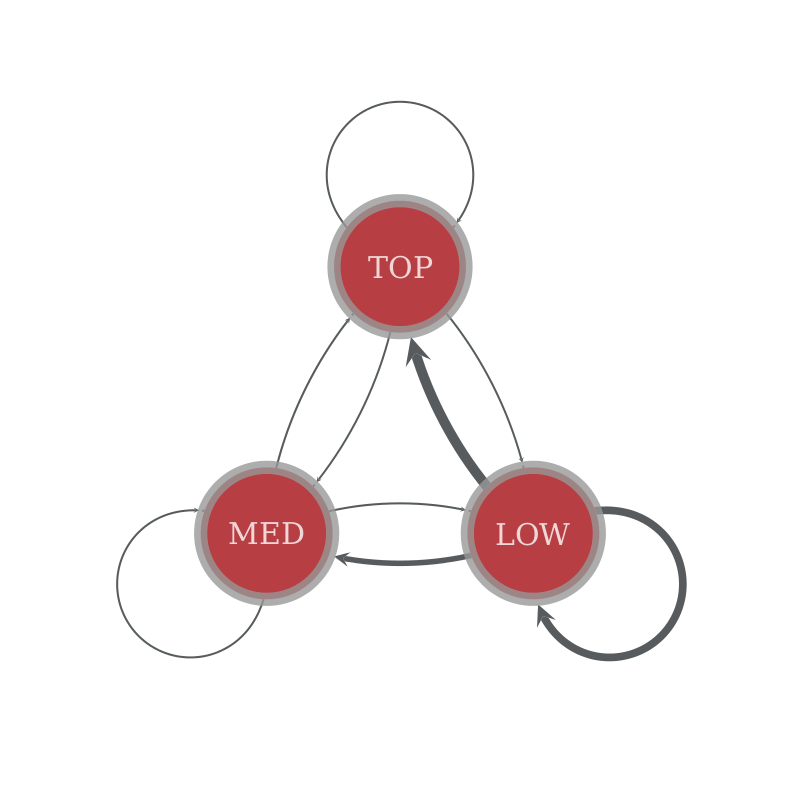

weight edges
draw biased graph


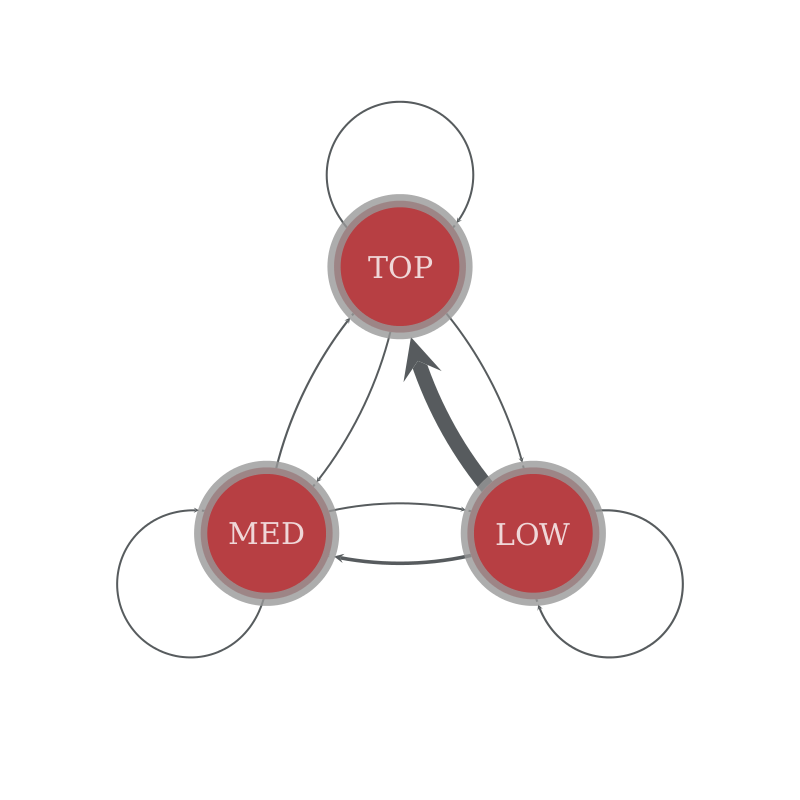

weight edges
draw biased graph


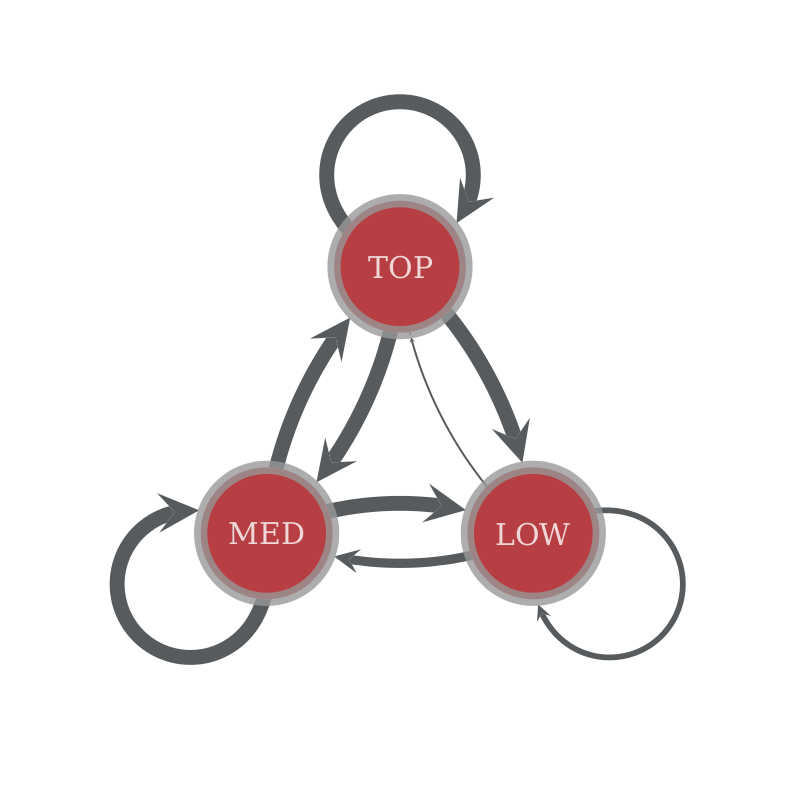

weight edges
draw biased graph


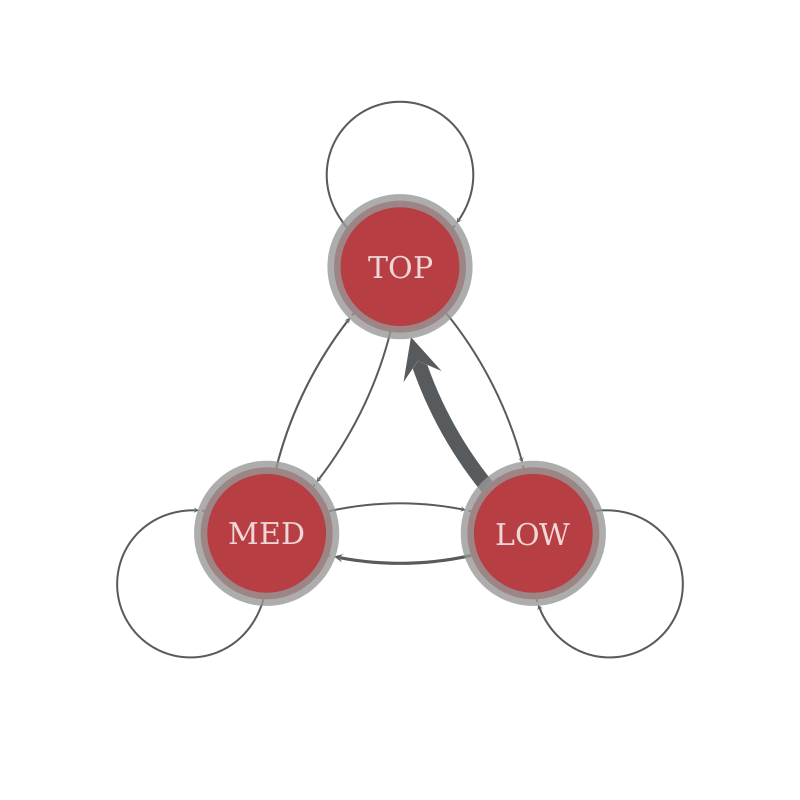

---rewired---
measure: out
max measure: 64695
min measure: 1
TOP limit: 21565
MED limit: 809
categorize nodes
node dist
TOP 59
MED 220
LOW 21287
urls samples---------
MED
	 http://www.milan-spiele.de/jaipur-p-11032.html
	 http://www.milan-spiele.de/cool-mini-m-533.html
	 http://www.milan-spiele.de/pegasus-spiele-m-80.html
	 http://www.milan-spiele.de/ferti-m-92.html
	 http://www.milan-spiele.de/palast-alhambra-stunde-diebe-p-4723.html
	 http://www.milan-spiele.de/plaid-games-m-416.html
	 http://www.milan-spiele.de/heckmeck-bratwurmeck-p-4497.html
	 http://www.milan-spiele.de/jungle-jam-p-1983.html
	 http://www.milan-spiele.de/matagot-m-242.html
	 http://www.milan-spiele.de/galaxy-trucker-engl-p-8057.html
TOP
	 http://www.milan-spiele.de/experimentierkaesten-c-175.html
	 http://www.milan-spiele.de/messe2014_02.php
	 http://www.milan-spiele.de/wortspiele-c-90.html
	 http://www.milan-spiele.de/partner.php
	 http://www.milan-spiele.de/bundle-deutschengl-p-17332.html
	 http://www.milan-spie

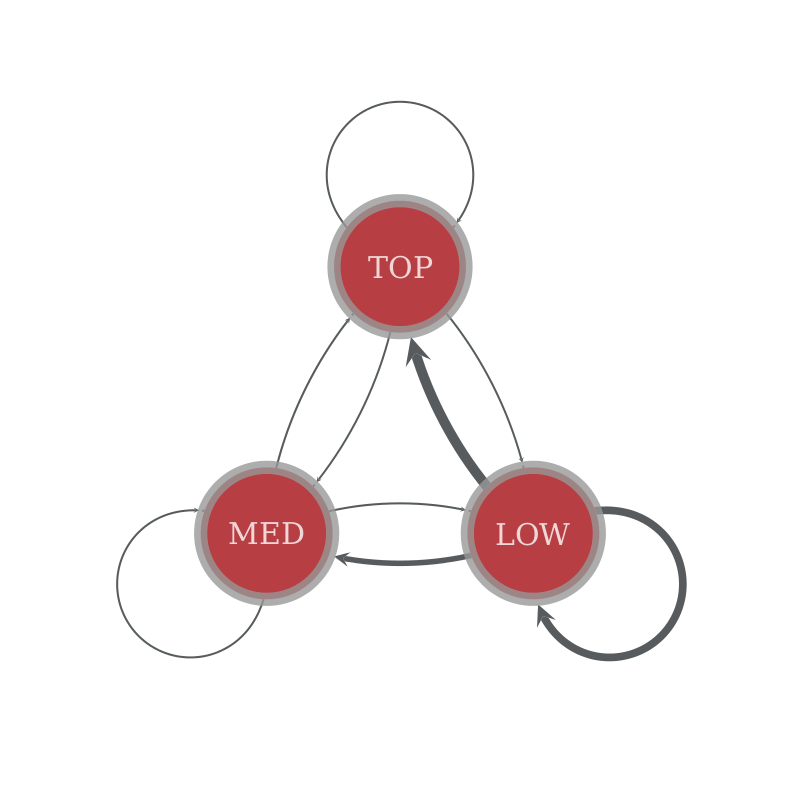

weight edges
draw biased graph


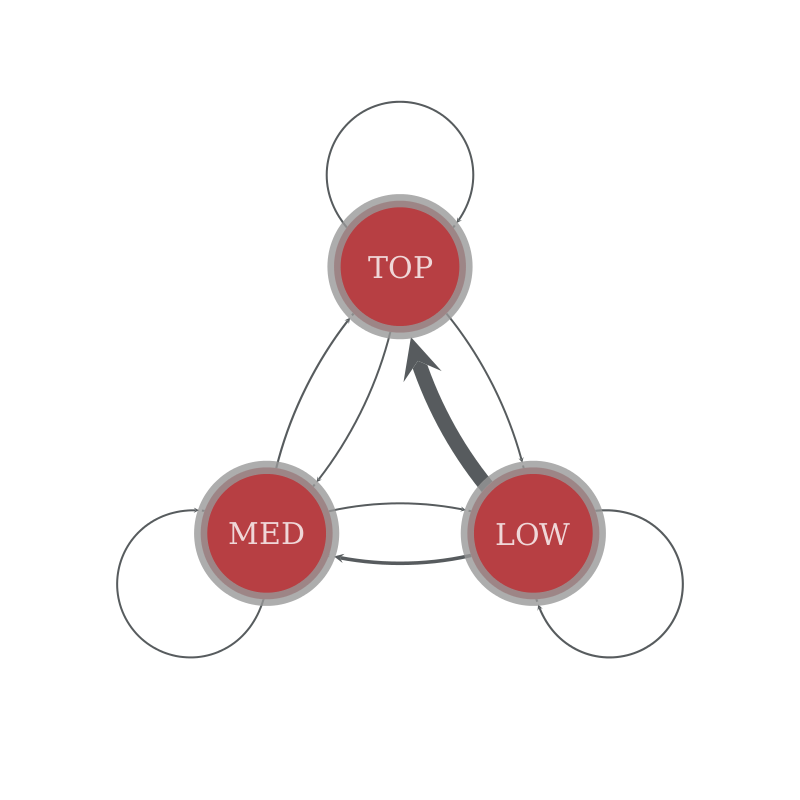

weight edges
draw biased graph


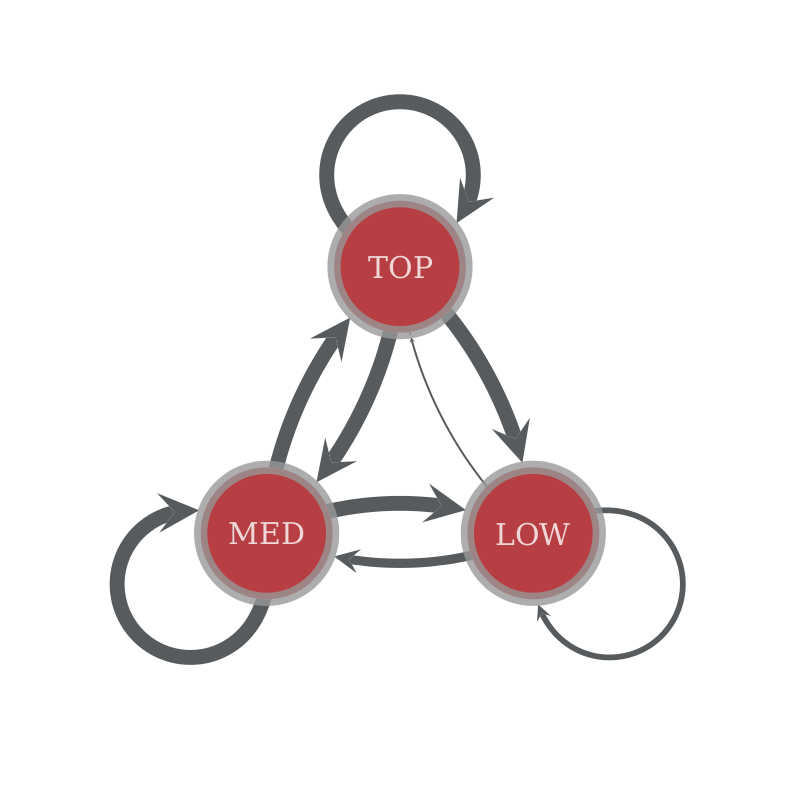

weight edges
draw biased graph


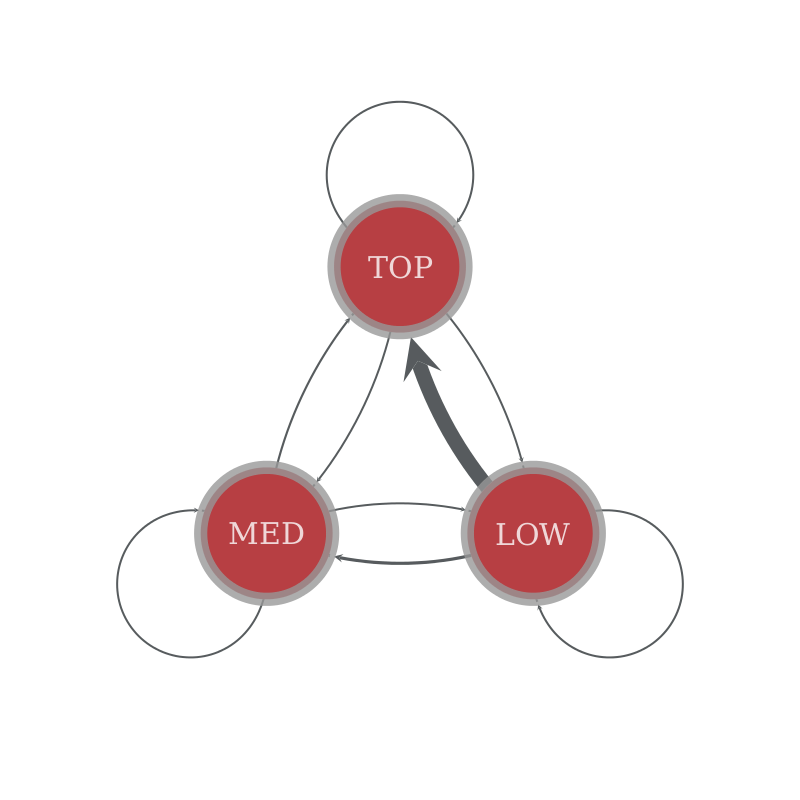

=================================getdigital_eu==================================
get network: getdigital_eu
	 getdigital_eu : 8477 v 1471764 e
measure: out
max measure: 66961
min measure: 1
TOP limit: 25463
MED limit: 8630
categorize nodes
node dist
TOP 17
MED 32
LOW 8428
urls samples---------
MED
	 www.getdigital.eu/gifts/valentines-day
	 www.getdigital.eu/shop/fun-and-games
	 www.getdigital.eu/gifts/funny
	 www.getdigital.eu/infos/waranty.html
	 www.getdigital.eu/account/overview.html
	 www.getdigital.eu/shop/useful-stuff
	 www.getdigital.eu/shop/star-trek
	 www.getdigital.eu/shop/clothing/computer-games
	 www.getdigital.eu/gifts/birthday
	 www.getdigital.eu/shop/scientific-stuff
TOP
	 www.getdigital.eu/infos/contact.html
	 www.getdigital.eu/infos/delivery_time.html
	 www.getdigital.eu/infos/terms.html
	 www.getdigital.eu/infos/privacy.html
	 www.getdigital.eu/shop/star-wars
	 www.getdigital.eu/infos/payment_types.html
	 www.getdigital.eu/infos/aboutus.html
	 www.getdigital.eu/gifts


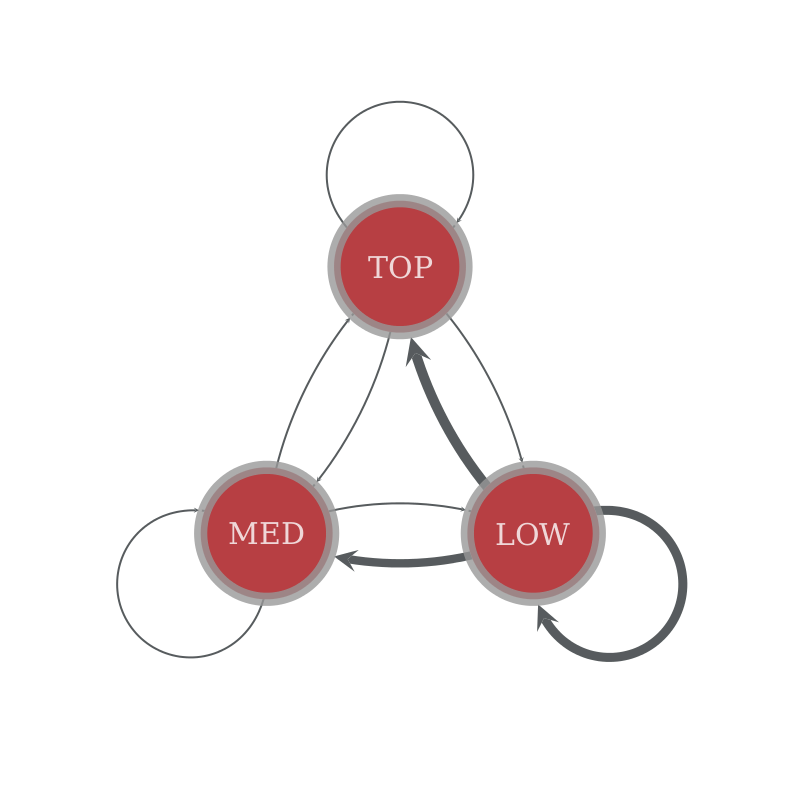

weight edges
draw biased graph


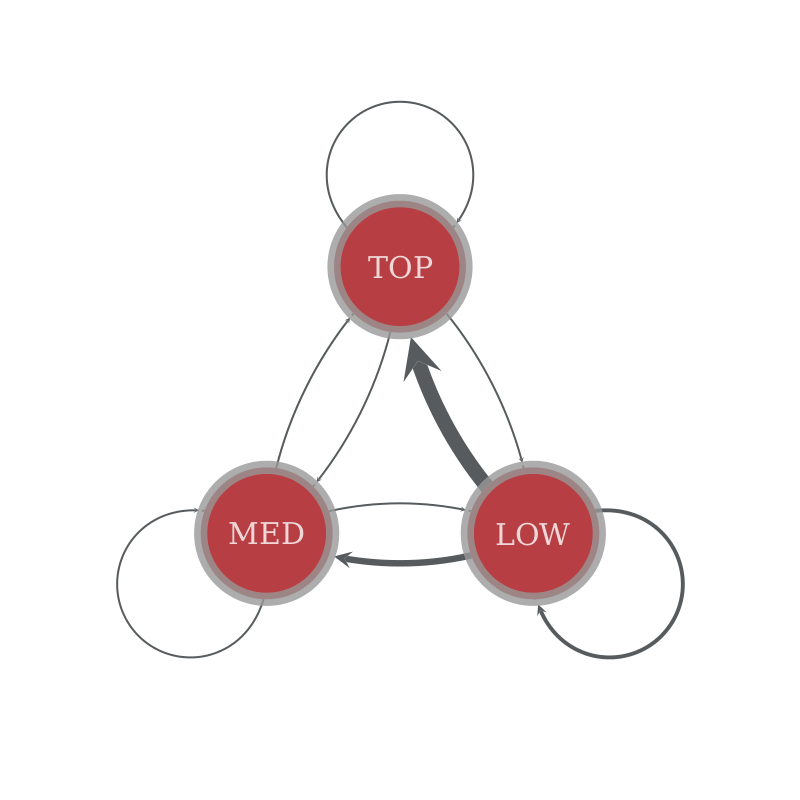

weight edges
draw biased graph


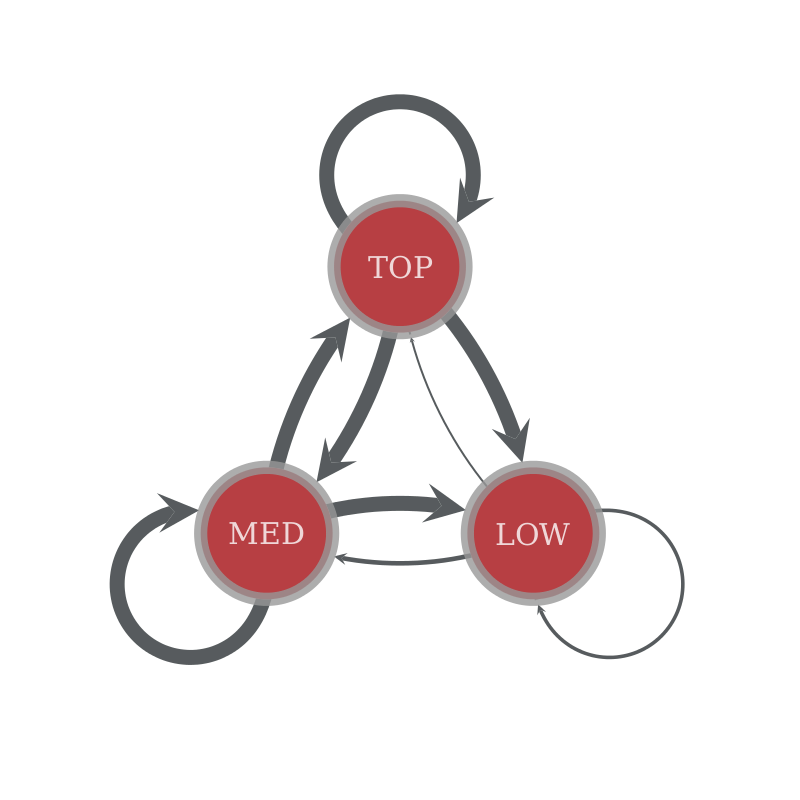

weight edges
draw biased graph


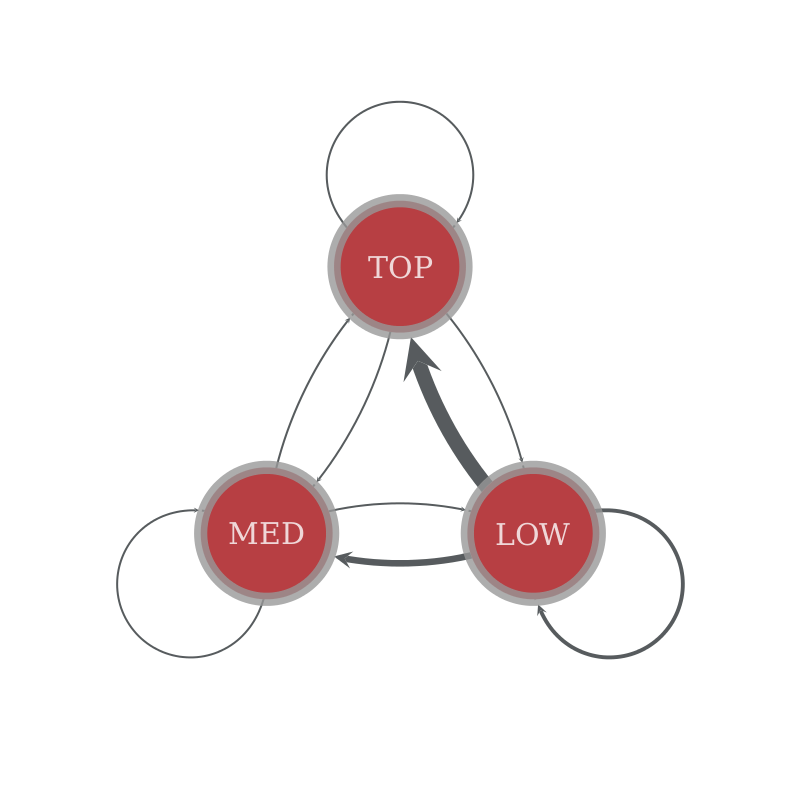

---rewired---
measure: out
max measure: 66961
min measure: 1
TOP limit: 25463
MED limit: 8630
categorize nodes
node dist
TOP 17
MED 32
LOW 8428
urls samples---------
MED
	 www.getdigital.eu/shop/news
	 www.getdigital.eu/shop/the-big-bang-theory
	 www.getdigital.eu/gifts/christmas-gifts
	 www.getdigital.eu/gifts/men
	 www.getdigital.eu/shop/clothing/computer-science
	 www.getdigital.eu/shop/promotions
	 www.getdigital.eu/shop/scientific-stuff
	 www.getdigital.eu/shop/clothing/computer-games
	 www.getdigital.eu/gifts/valentines-day
	 www.getdigital.eu/infos/fairwear.html
TOP
	 www.getdigital.eu/shop/merchandise
	 www.getdigital.eu/shop
	 www.getdigital.eu/infos/imprint.html
	 www.getdigital.eu/infos/payment_types.html
	 www.getdigital.eu/shop/star-wars
	 www.getdigital.eu/infos/terms.html
	 www.getdigital.eu/infos/aboutus.html
	 www.getdigital.eu/infos/shipping_costs.html
	 www.getdigital.eu/infos/contact.html
	 www.getdigital.eu/infos/customs.html
LOW
	 www.getdigital.eu/shop/portal/mer

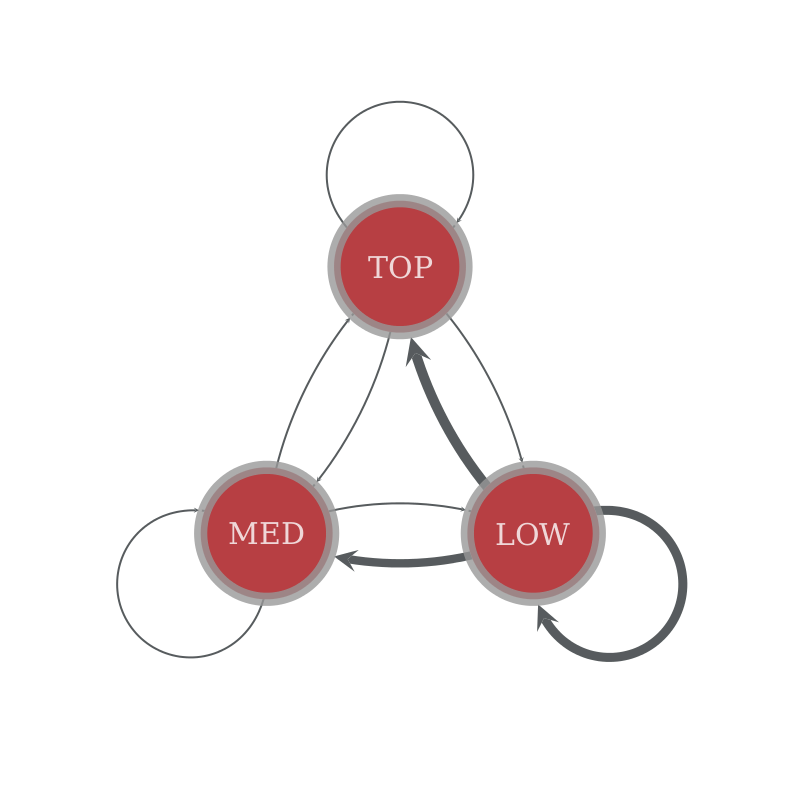

weight edges
draw biased graph


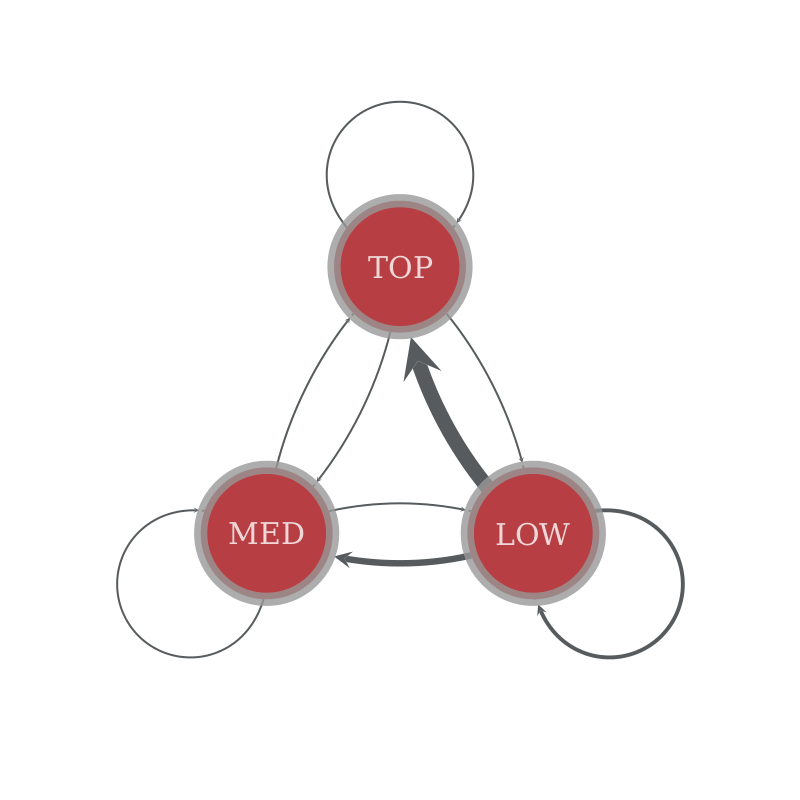

weight edges
draw biased graph


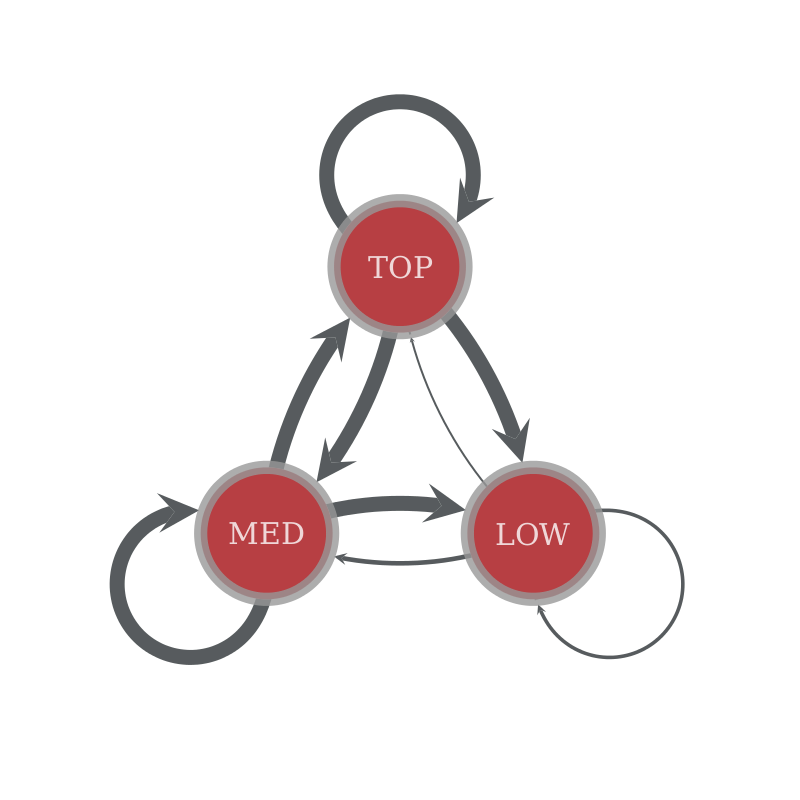

weight edges
draw biased graph


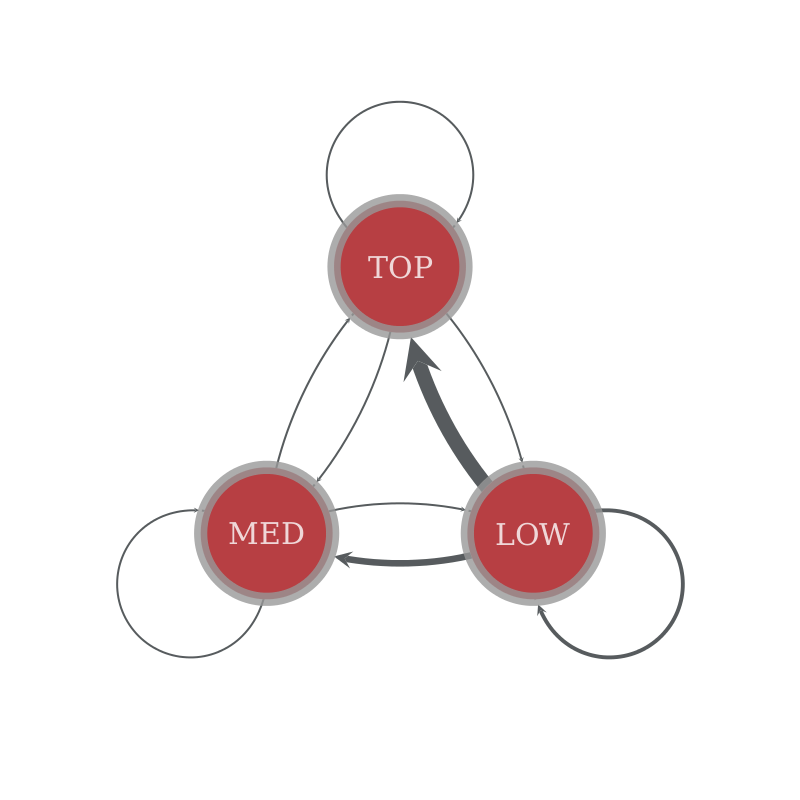

===================================thinkgeek====================================
get network: thinkgeek
	 thinkgeek : 3884 v 1002226 e
measure: out
max measure: 23014
min measure: 1
TOP limit: 4419
MED limit: 3867
categorize nodes
node dist
TOP 52
MED 114
LOW 3718
urls samples---------
MED
	 http://www.thinkgeek.com/interests/minecraft/
	 http://www.thinkgeek.com/interests/superheroes/
	 http://www.thinkgeek.com/interests/unicorns/
	 http://www.thinkgeek.com/electronics-gadgets/all/
	 http://www.thinkgeek.com/interests/everyday-carry/
	 http://www.thinkgeek.com/whats-new/
	 http://www.thinkgeek.com/action-shots/
	 http://www.thinkgeek.com/geek-kids/7-13-years/
	 http://www.thinkgeek.com/electronics-gadgets/camera-photo-video/
	 http://www.thinkgeek.com/geek-kids/all/
TOP
	 http://www.thinkgeek.com/electronics-gadgets/
	 http://www.thinkgeek.com/video-games/
	 http://www.thinkgeek.com/homeoffice/all/
	 http://www.thinkgeek.com/tshirts-apparel/all/
	 http://www.thinkgeek.com/homeoffice/l

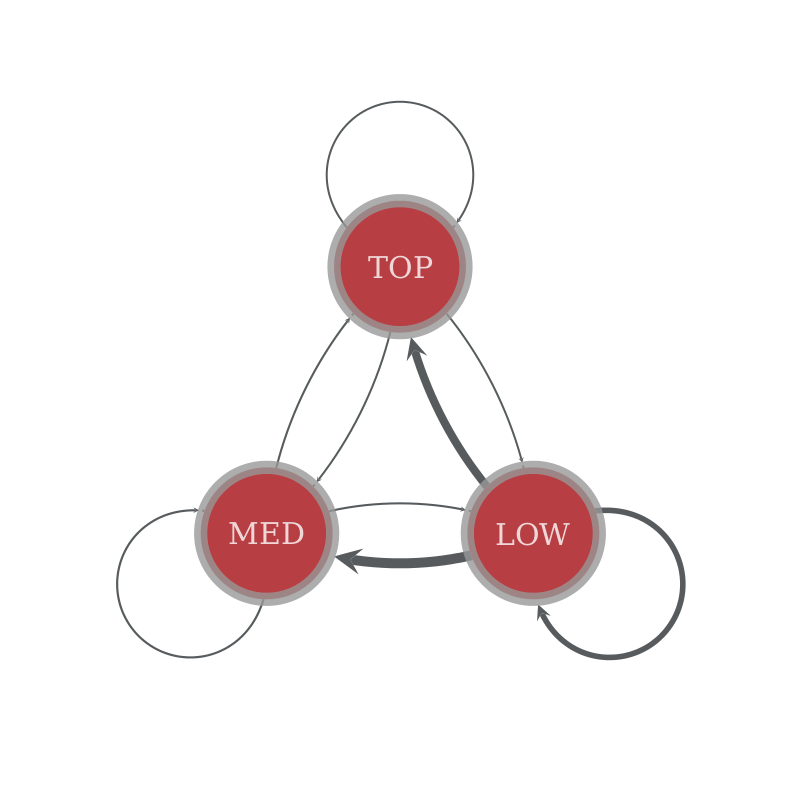

weight edges
draw biased graph


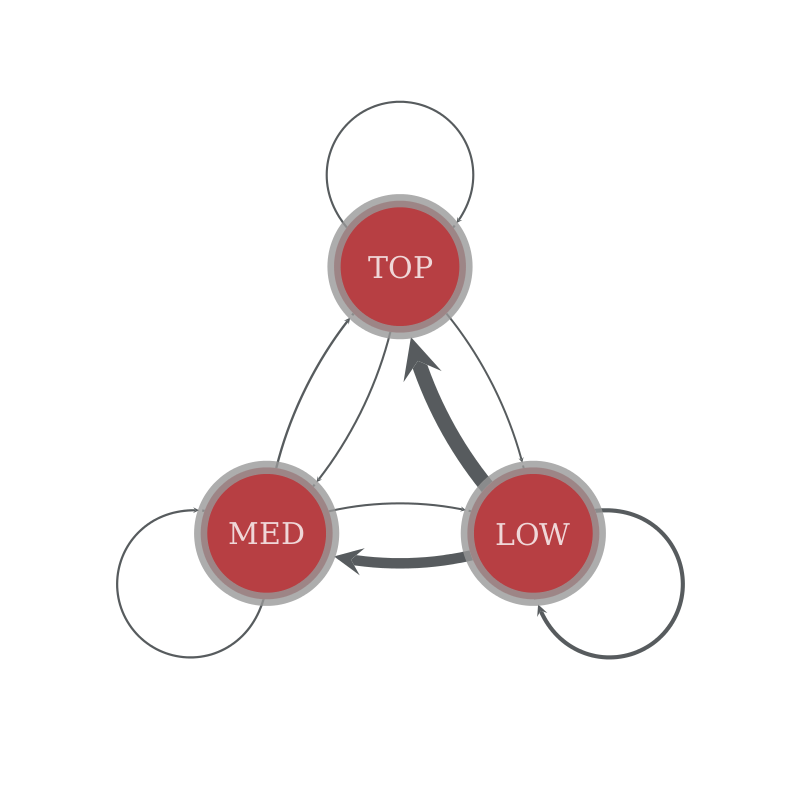

weight edges
draw biased graph


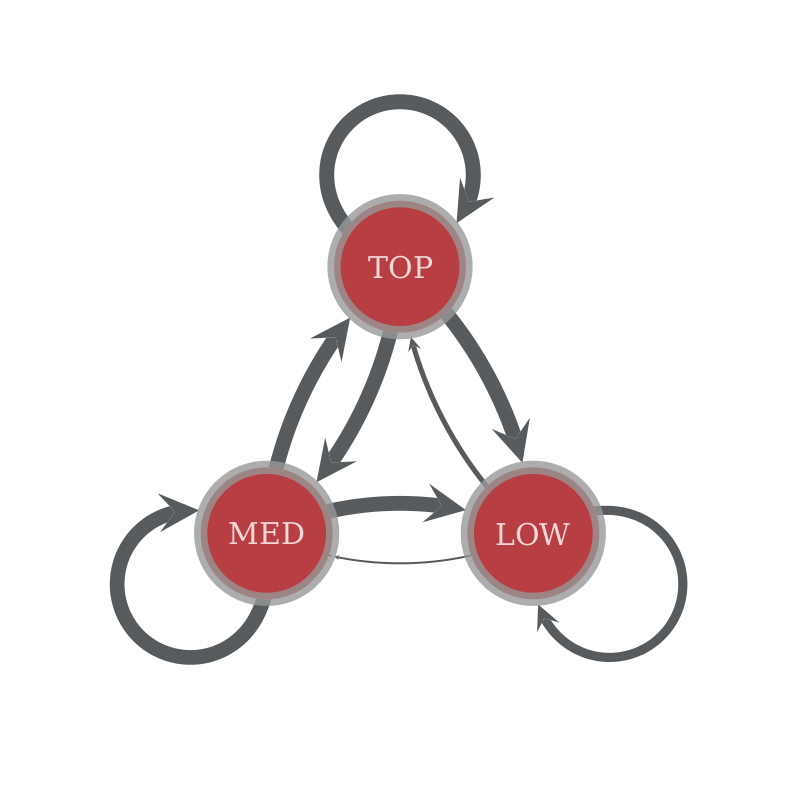

weight edges
draw biased graph


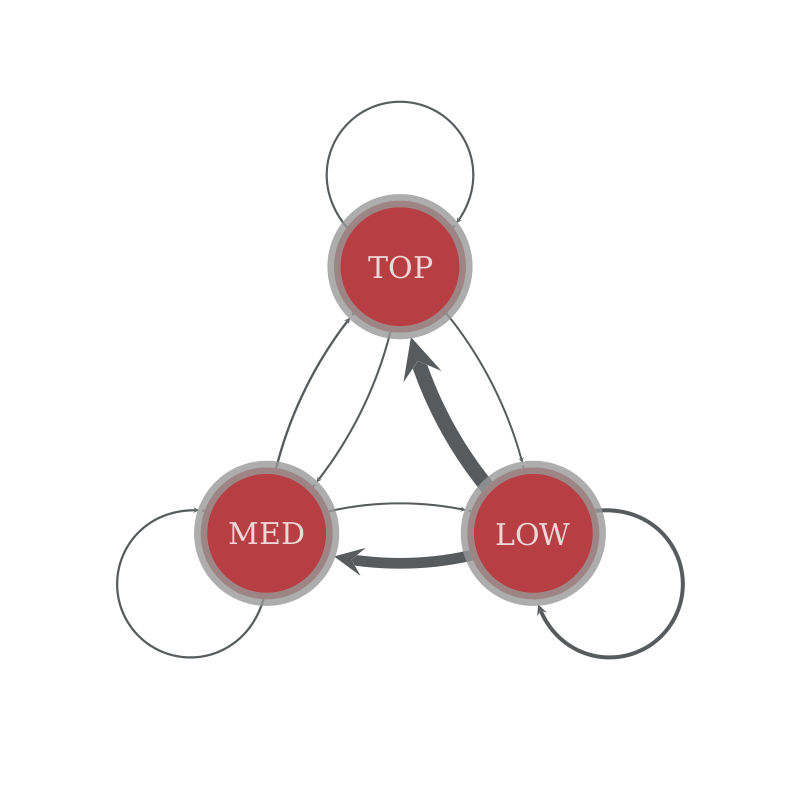

---rewired---
measure: out
max measure: 23014
min measure: 1
TOP limit: 4419
MED limit: 3867
categorize nodes
node dist
TOP 52
MED 114
LOW 3718
urls samples---------
MED
	 http://www.thinkgeek.com/electronics-gadgets/console-portable-gaming/
	 http://www.thinkgeek.com/interests/firefly/
	 http://www.thinkgeek.com/interests/roccat/
	 http://www.thinkgeek.com/brain/account/passwd.cgi
	 http://www.thinkgeek.com/geek-kids/all/newest/desc/0/100/
	 http://www.thinkgeek.com/tools-outdoor-survival/survival-camping-gear/
	 http://www.thinkgeek.com/interests/gamer/
	 http://www.thinkgeek.com/interests/pop-vinyl/
	 http://www.thinkgeek.com/electronics-gadgets/usb-accessories/
	 http://www.thinkgeek.com/electronics-gadgets/car-accessories/
TOP
	 http://www.thinkgeek.com/brain/order/certificate.cgi
	 http://www.thinkgeek.com/tshirts-apparel/socks-underwear/
	 http://www.thinkgeek.com/tshirts-apparel/kids/
	 http://www.thinkgeek.com/tshirts-apparel/unisex/all/
	 http://www.thinkgeek.com/geekpoints/


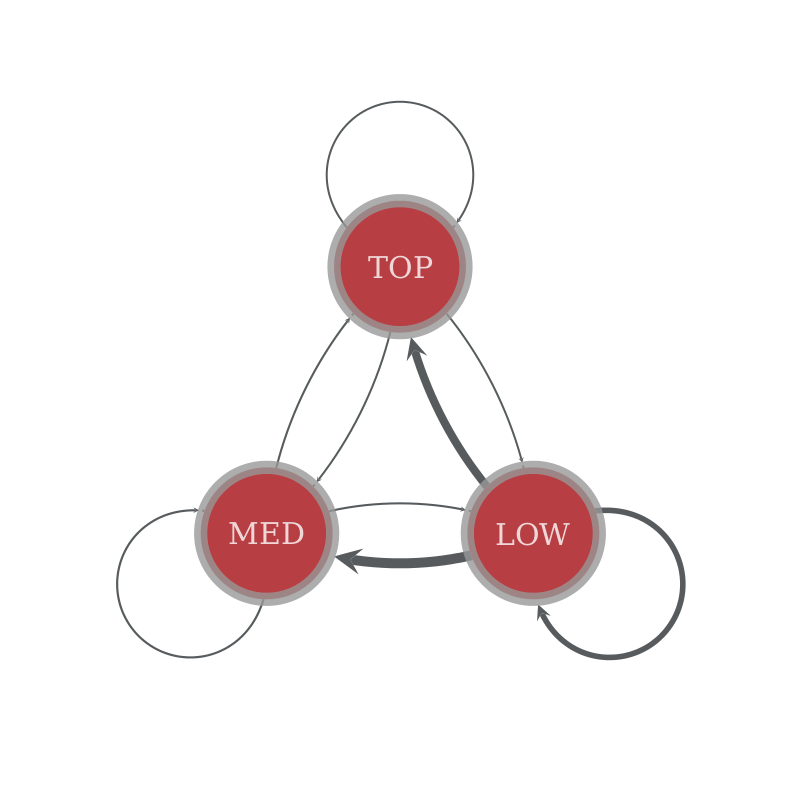

weight edges
draw biased graph


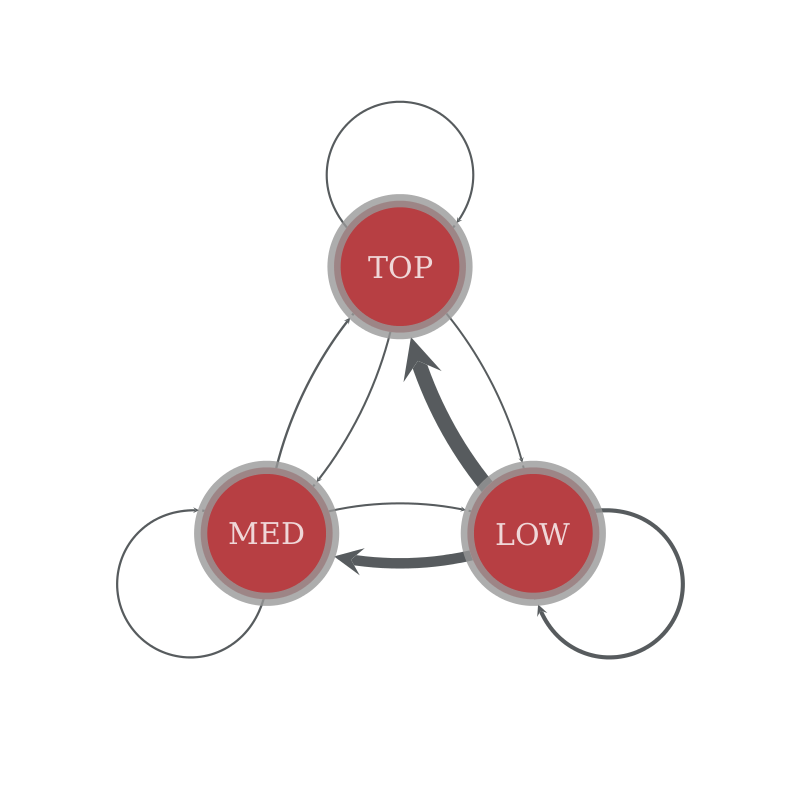

weight edges
draw biased graph


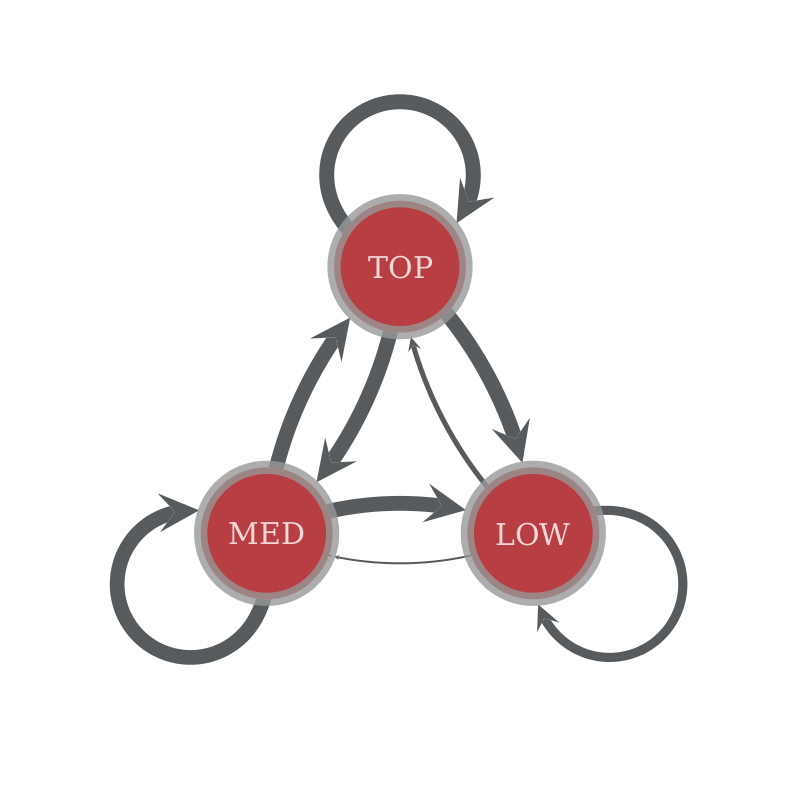

weight edges
draw biased graph


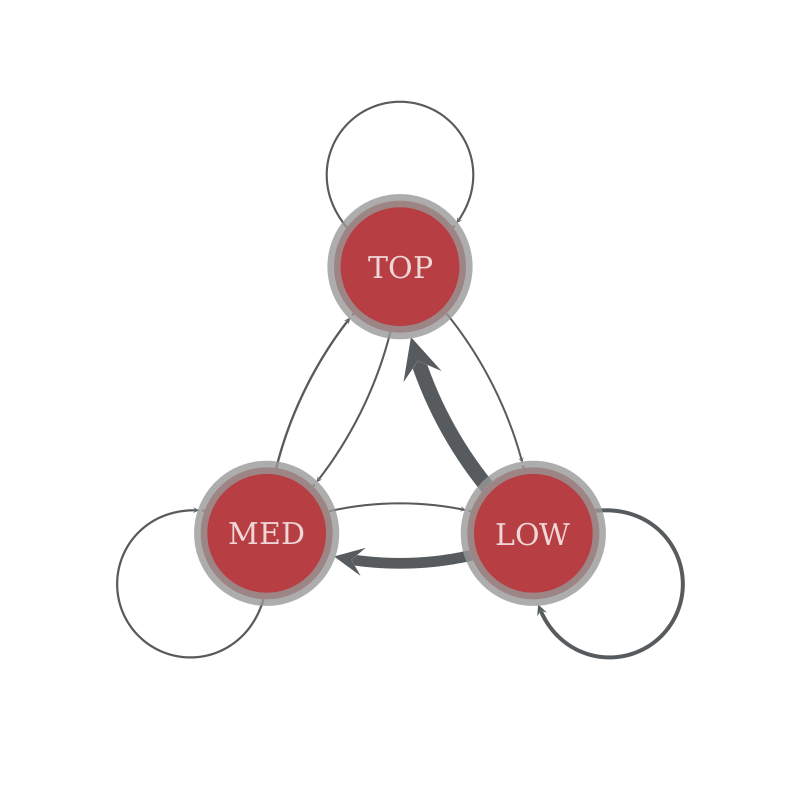

====================================bar_wiki====================================
get network: bar_wiki
	 bar_wiki : 32734 v 1324839 e
measure: out
max measure: 65529
min measure: 1
TOP limit: 670
MED limit: 161
categorize nodes
node dist
TOP 103
MED 1468
LOW 31163
urls samples---------
MED
	 https://bar.wikipedia.org/wiki/Wright_County_(Iowa)
	 https://bar.wikipedia.org/wiki/Countys_in_Kansas
	 https://bar.wikipedia.org/wiki/Crawford_County_(Indiana)
	 https://bar.wikipedia.org/wiki/Zapata_County
	 https://bar.wikipedia.org/wiki/Gratiot_County
	 https://bar.wikipedia.org/wiki/Swisher_County
	 https://bar.wikipedia.org/wiki/Benton_County_(Indiana)
	 https://bar.wikipedia.org/wiki/Morris_County_(Kansas)
	 https://bar.wikipedia.org/wiki/Landkreis_Garmisch-Partnkira
	 https://bar.wikipedia.org/wiki/SP%C3%96
TOP
	 https://bar.wikipedia.org/wiki/Minga
	 https://bar.wikipedia.org/wiki/Frankreich
	 https://bar.wikipedia.org/wiki/Nutza:El_bes
	 https://bar.wikipedia.org/wiki/Schweiz
	 https://b

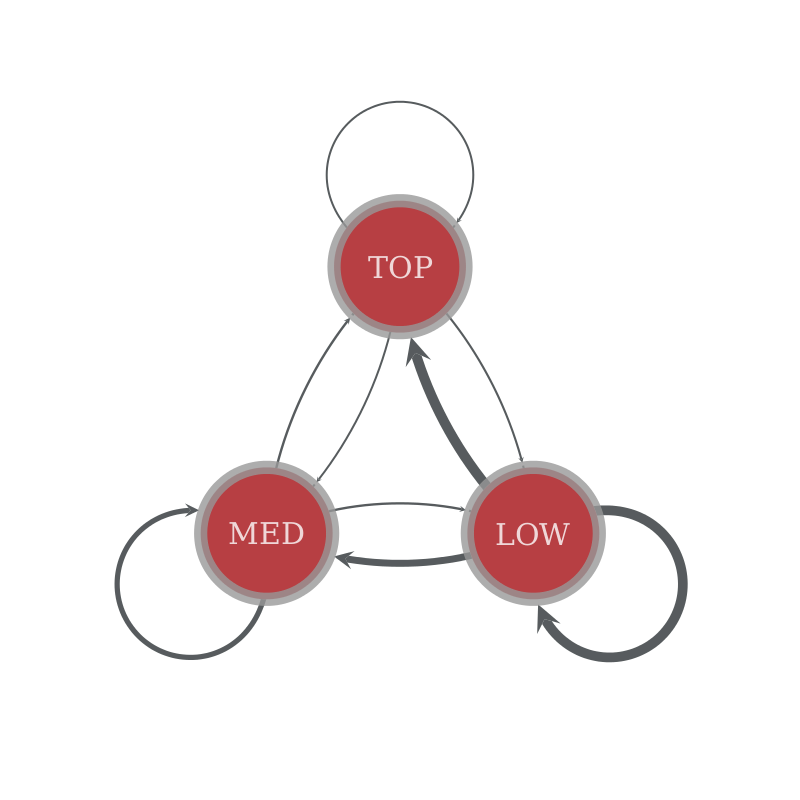

weight edges
draw biased graph


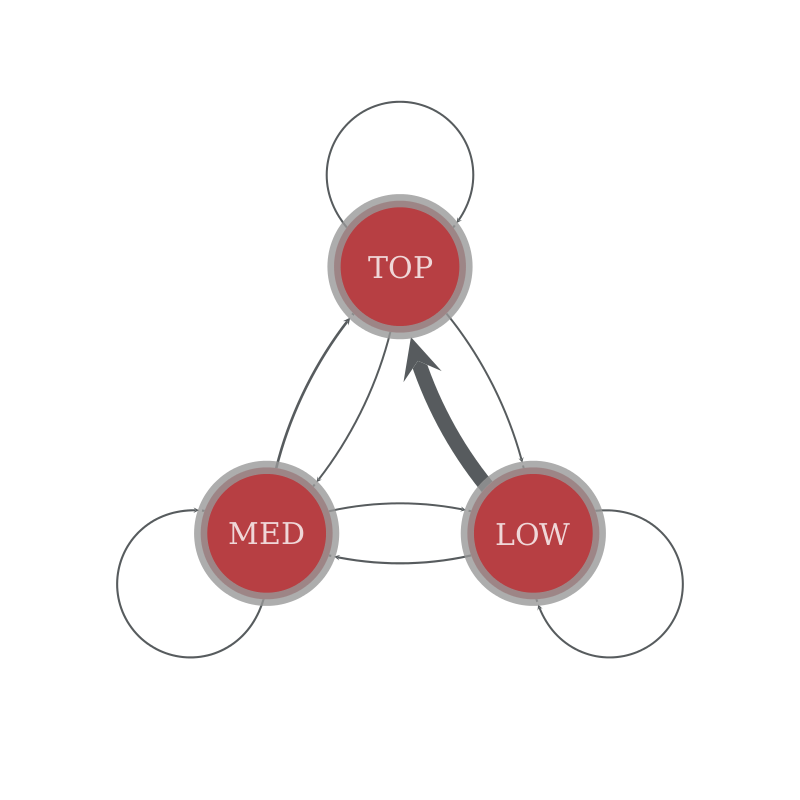

weight edges
draw biased graph


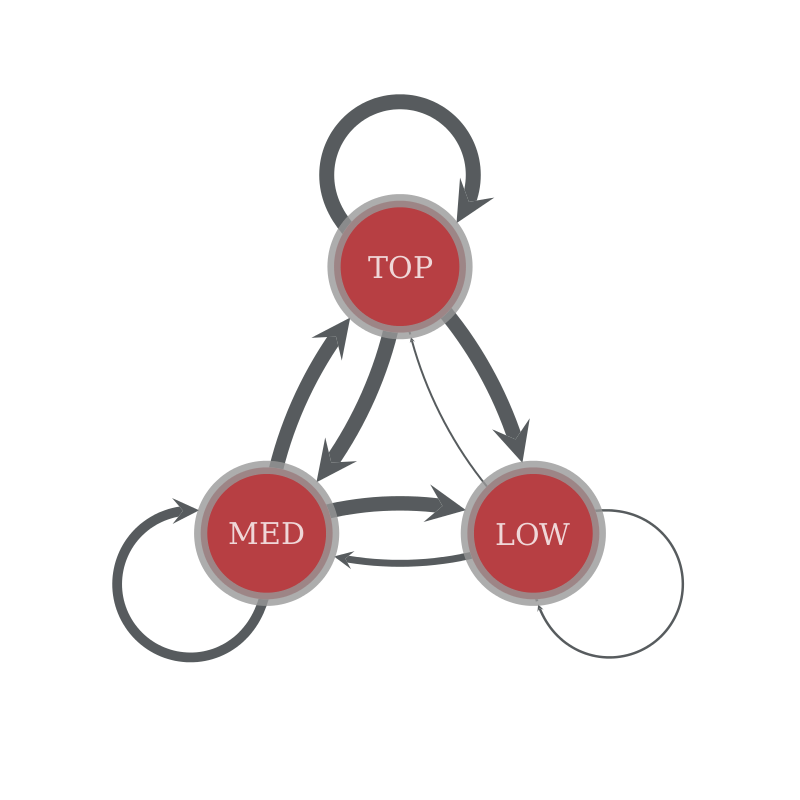

weight edges
draw biased graph


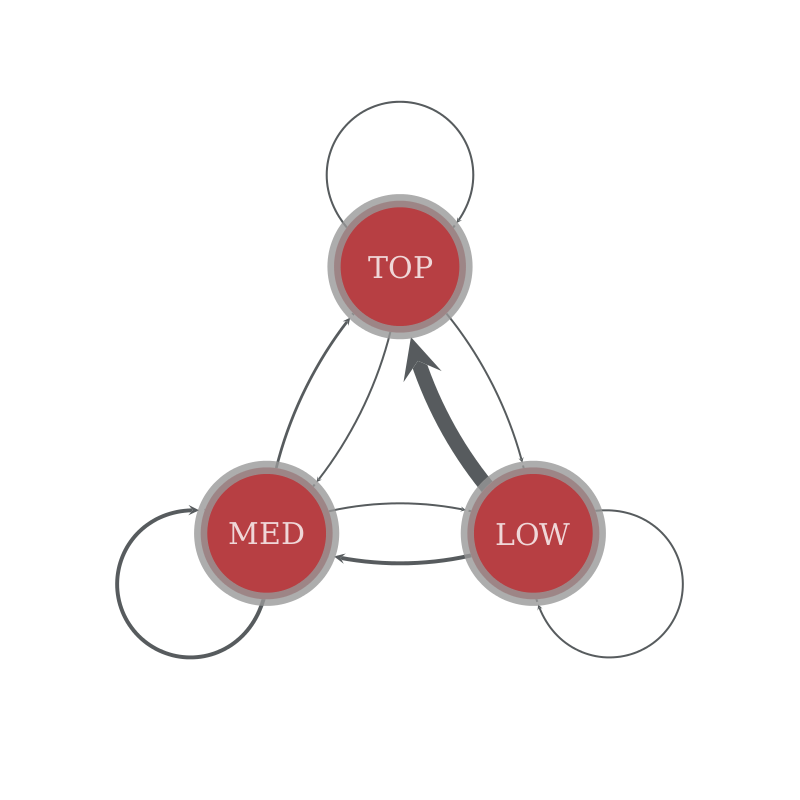

---rewired---
measure: out
max measure: 65529
min measure: 1
TOP limit: 670
MED limit: 161
categorize nodes
node dist
TOP 103
MED 1468
LOW 31163
urls samples---------
MED
	 https://bar.wikipedia.org/wiki/Landkreis_Rh%C3%B6n-Grabfeld
	 https://bar.wikipedia.org/wiki/Cheyenne_County_(Kansas)
	 https://bar.wikipedia.org/wiki/Effingham_County_(Illinois)
	 https://bar.wikipedia.org/wiki/Bay_County_(Michigan)
	 https://bar.wikipedia.org/wiki/Elbert_County_(Georgia)
	 https://bar.wikipedia.org/wiki/Nutza_Dischkrian:RobTorgel
	 https://bar.wikipedia.org/wiki/Washington_County_(Iowa)
	 https://bar.wikipedia.org/wiki/McLennan_County
	 https://bar.wikipedia.org/wiki/Ida_County
	 https://bar.wikipedia.org/wiki/Mason_County_(Illinois)
TOP
	 https://bar.wikipedia.org/wiki/Biographien/X
	 https://bar.wikipedia.org/wiki/Biographien/B
	 https://bar.wikipedia.org/wiki/Kalifornien
	 https://bar.wikipedia.org/wiki/Kategorie:Artikel_auf_Westmittelbairisch
	 https://bar.wikipedia.org/wiki/Biographien/M
	 ht

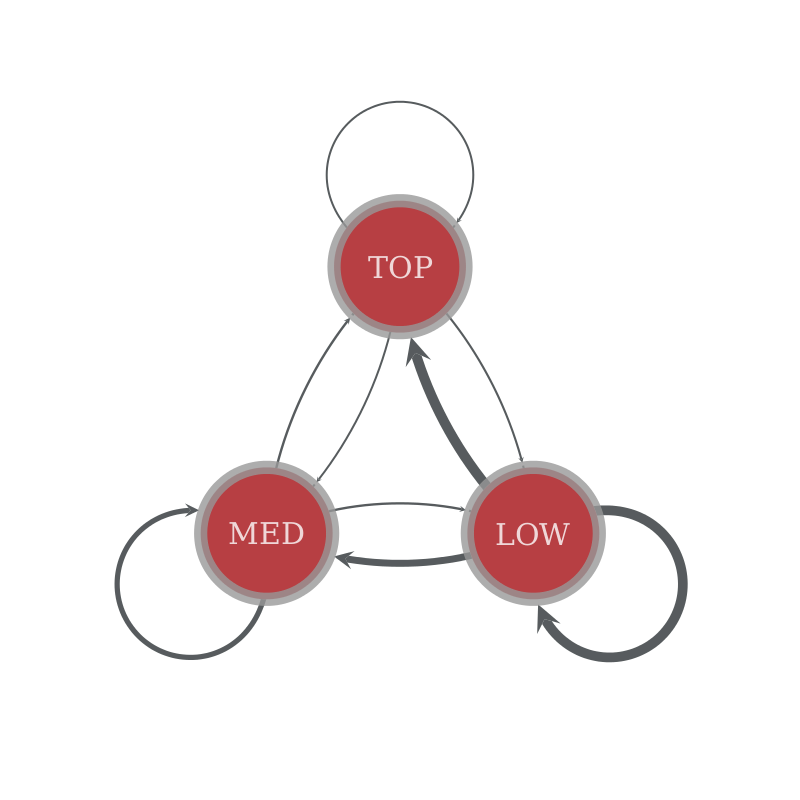

weight edges
draw biased graph


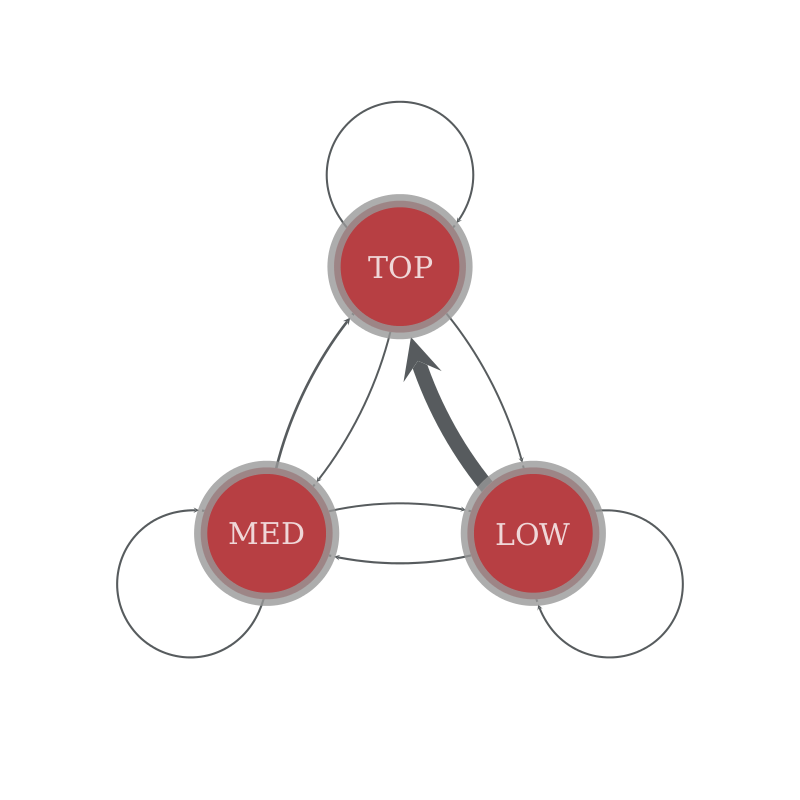

weight edges
draw biased graph


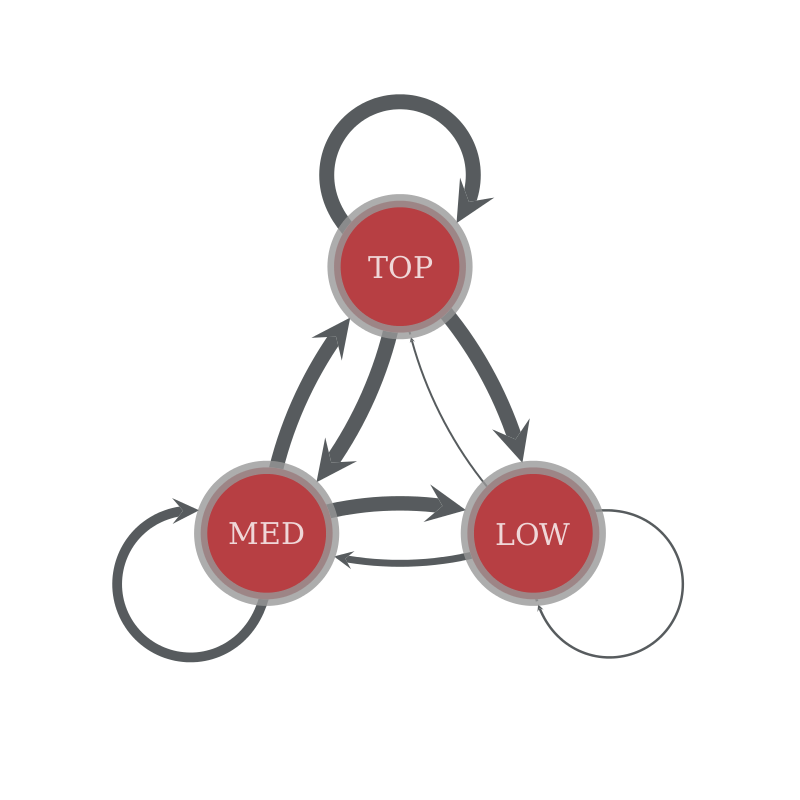

weight edges
draw biased graph


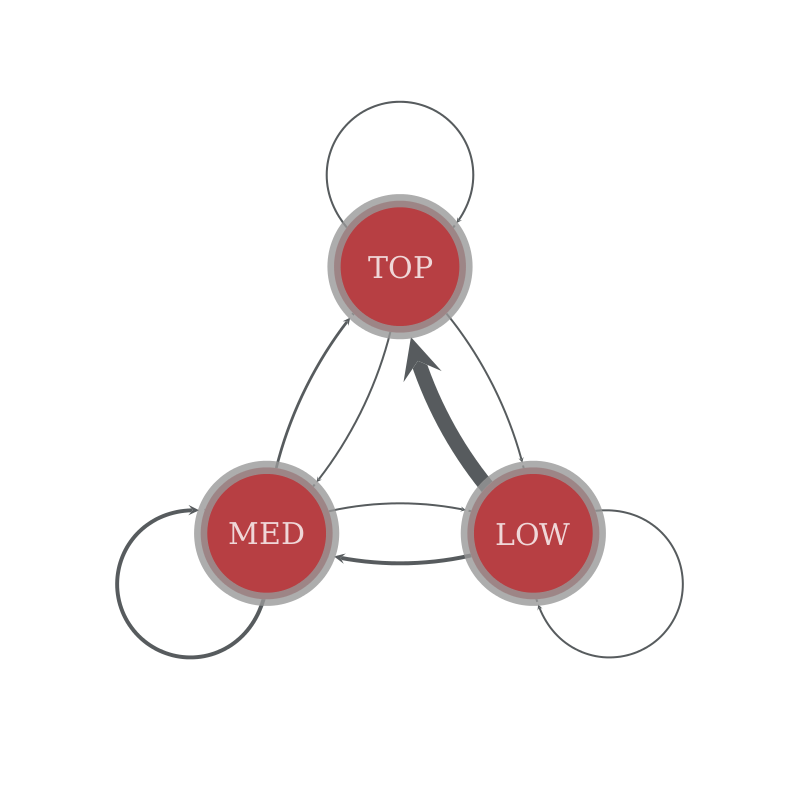

===================================tvthek_orf===================================
get network: tvthek_orf
	 tvthek_orf : 9799 v 301844 e
measure: out
max measure: 29394
min measure: 1
TOP limit: 2970
MED limit: 39
categorize nodes
node dist
TOP 20
MED 743
LOW 9036
urls samples---------
MED
	 http://tvthek.orf.at/topic/Kultur/6275545/Kultur-Heute-Spezial/10141178/Bachmann-Preis-an-Gomringer/10141503
	 http://tvthek.orf.at/program/Kaernten-heute/70022/Kaernten-heute/10153845
	 http://tvthek.orf.at/program/Wetter-Panorama/7268748/Wetter-Panorama/10091187/Hochficht-Bergstation/10163486
	 http://tvthek.orf.at/program/Wien-heute/70018/Wien-heute/10151656
	 http://tvthek.orf.at/program/Nationalrat/3096617/Nationalratssitzung-IX/10161446/Abstimmung/10162085
	 http://tvthek.orf.at/topic/Festspielsommer/10166040/heute-leben/10172413/Festspiele-Schloss-Weitra/10172422
	 http://tvthek.orf.at/topic/Inland/6909379/ZIB-2/10161336/Busse-als-Unterkunft-fuer-Fluechtlinge/10161641
	 http://tvthek.orf.at/p

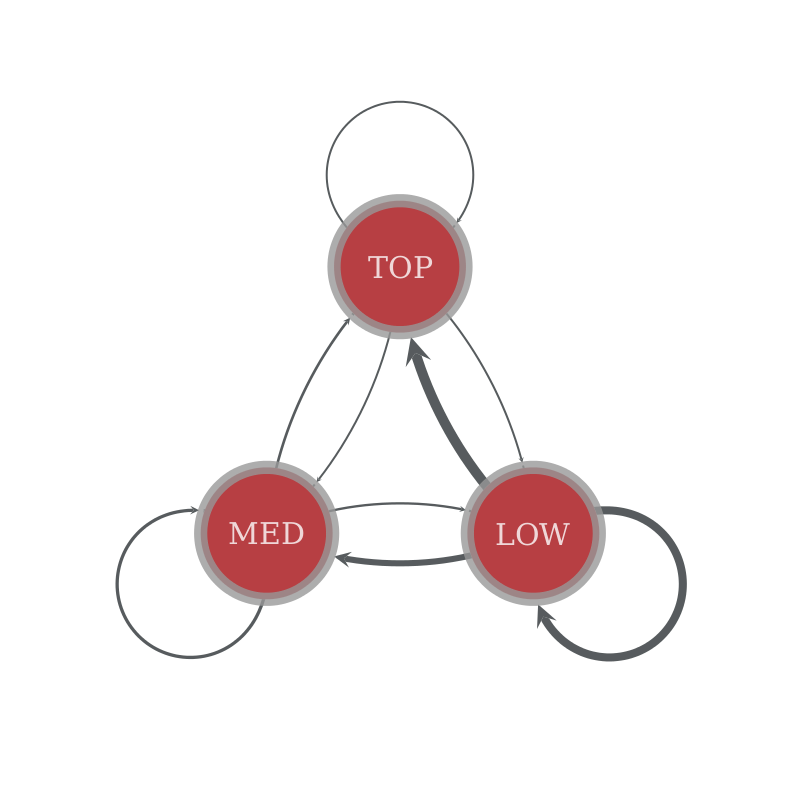

weight edges
draw biased graph


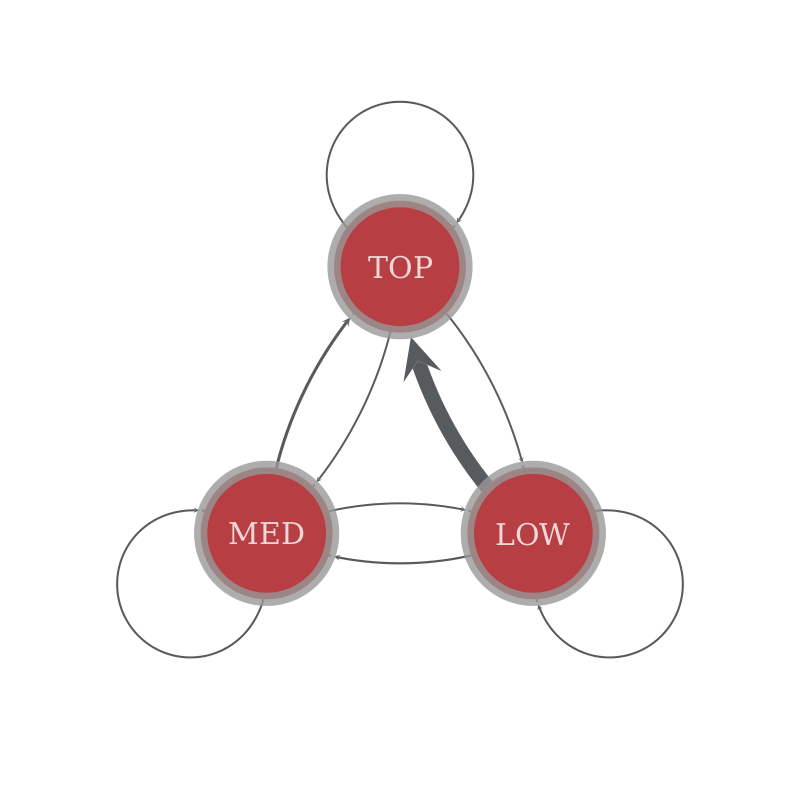

weight edges
draw biased graph


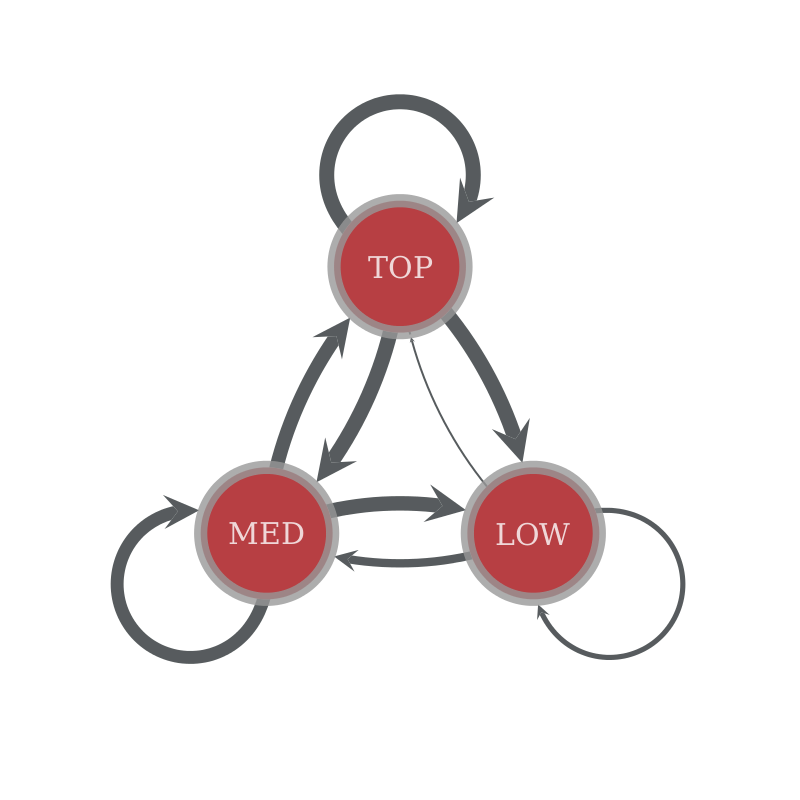

weight edges
draw biased graph


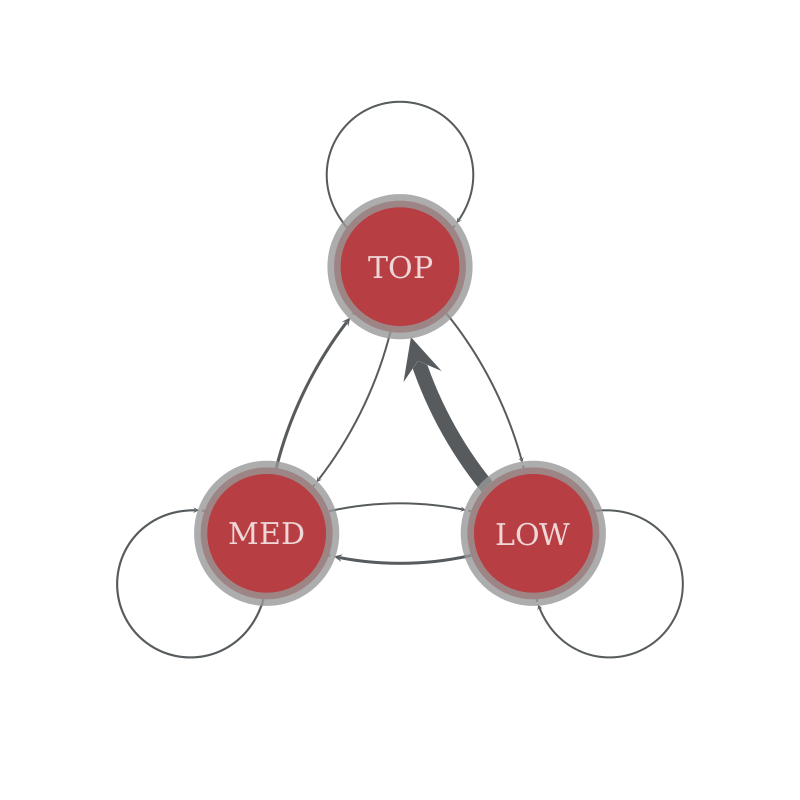

---rewired---
measure: out
max measure: 29394
min measure: 1
TOP limit: 2970
MED limit: 39
categorize nodes
node dist
TOP 20
MED 743
LOW 9036
urls samples---------
MED
	 http://tvthek.orf.at/topic/Leben-und-Lifestyle/7174244/heute-konkret/10164698/Mietwagen/10164701
	 http://tvthek.orf.at/program/Sport-Bild/1379/Sport-Bild/10181463
	 http://tvthek.orf.at/program/Wetter-Panorama/7268748/Wetter-Panorama/10091189/Serfaus-Plansegg/10171616
	 http://tvthek.orf.at/program/Kultur-heute/3078759/Kultur-Heute/10173332
	 http://tvthek.orf.at/program/Wetter-Wien/8094871/Wetter-Wien/10180618
	 http://tvthek.orf.at/program/Kaernten-heute/70022/Kaernten-heute/10153845
	 http://tvthek.orf.at/program/Wetter-Panorama/7268748/Wetter-Panorama/10091187/Podersdorf/10163467
	 http://tvthek.orf.at/index.php/program/ZIB-Flash/1232/ZIB-Flash-1630/10143489
	 http://tvthek.orf.at/program/Nationalrat/3096617/Nationalratssitzung-VI/10157826
	 http://tvthek.orf.at/program/ZIB-1-OeGS/145302/ZIB-1-OeGS/10149937
TOP
	 

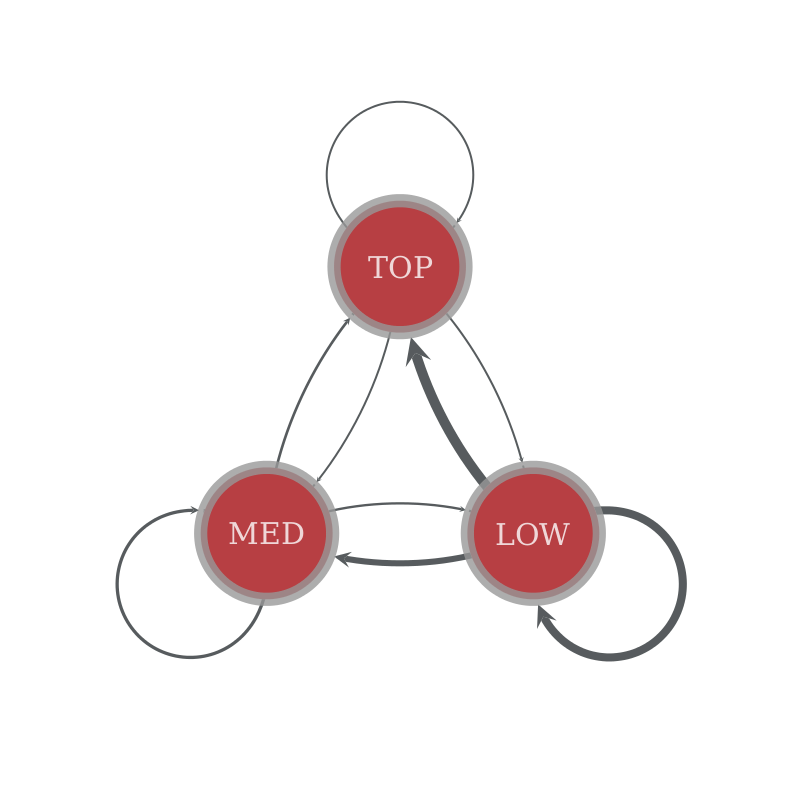

weight edges
draw biased graph


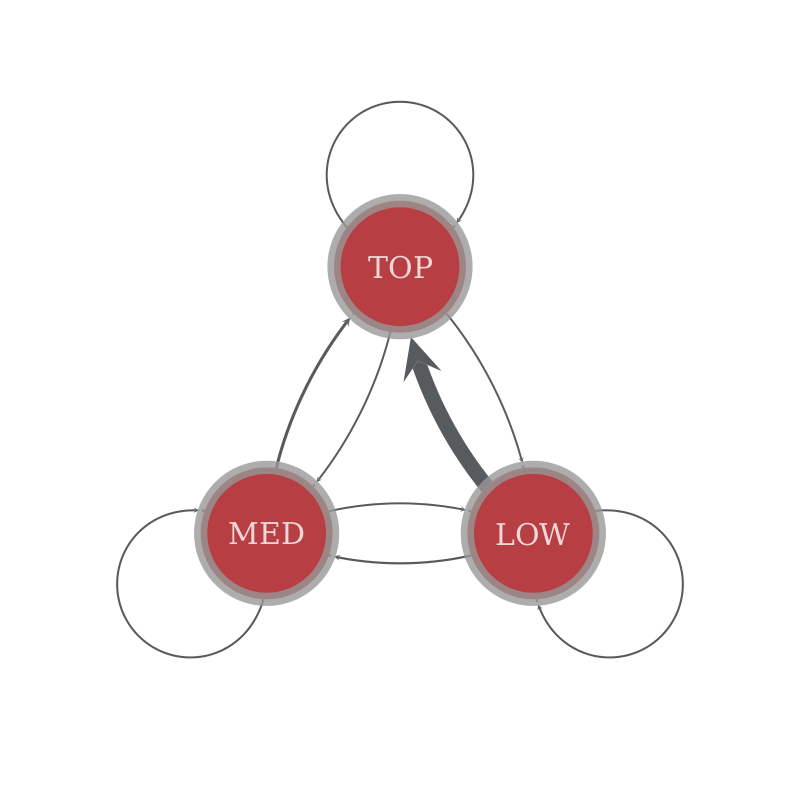

weight edges
draw biased graph


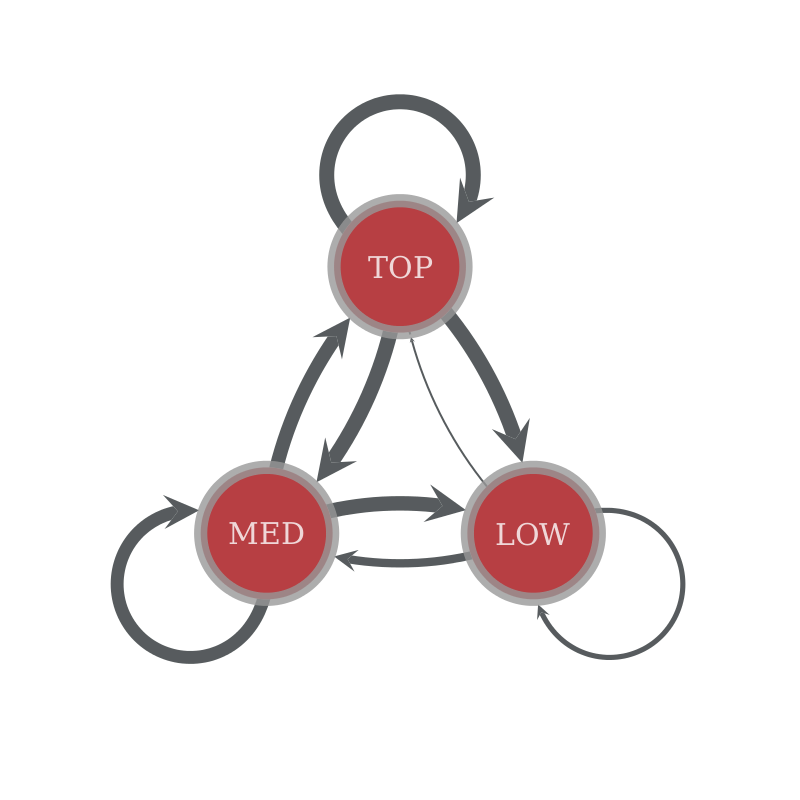

weight edges
draw biased graph


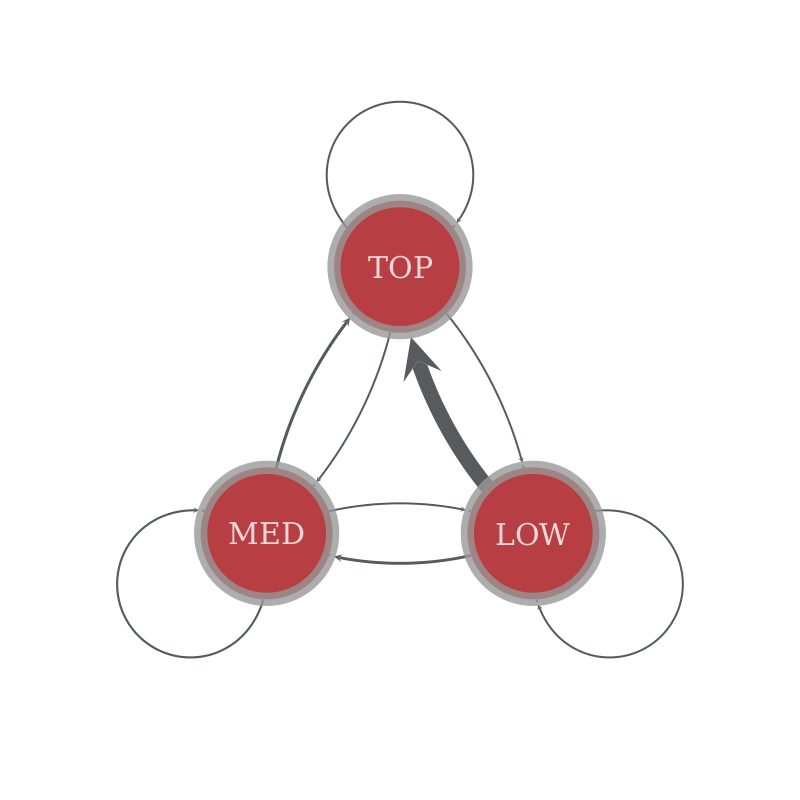

====================================daserste====================================
get network: daserste
	 daserste : 70063 v 3448513 e
measure: out
max measure: 210182
min measure: 1
TOP limit: 70059
MED limit: 70059
categorize nodes
node dist
TOP 38
MED 0
LOW 70025
urls samples---------
TOP
	 http://mediathek.daserste.de/sendungVerpasst?tag=6&topRessort
	 http://mediathek.daserste.de/sendungen-a-z?buchstabe=Z
	 http://mediathek.daserste.de/merkliste
	 http://mediathek.daserste.de/sendungen-a-z?buchstabe=T
	 http://mediathek.daserste.de/live
	 http://mediathek.daserste.de/sendungen-a-z?buchstabe=M
	 http://mediathek.daserste.de/sendungen-a-z?buchstabe=S
	 http://mediathek.daserste.de/sendungen-a-z?buchstabe=E
	 http://mediathek.daserste.de/sendungen-a-z?buchstabe=G
	 http://mediathek.daserste.de/sendungen-a-z?buchstabe=N
LOW
	 http://mediathek.daserste.de/Sportschau/Miriam-Gössner-So-ein-Rennen-tut-gut/Das-Erste/Video?documentId=26048994&topRessort&bcastId=53524
	 http://mediathek.daser

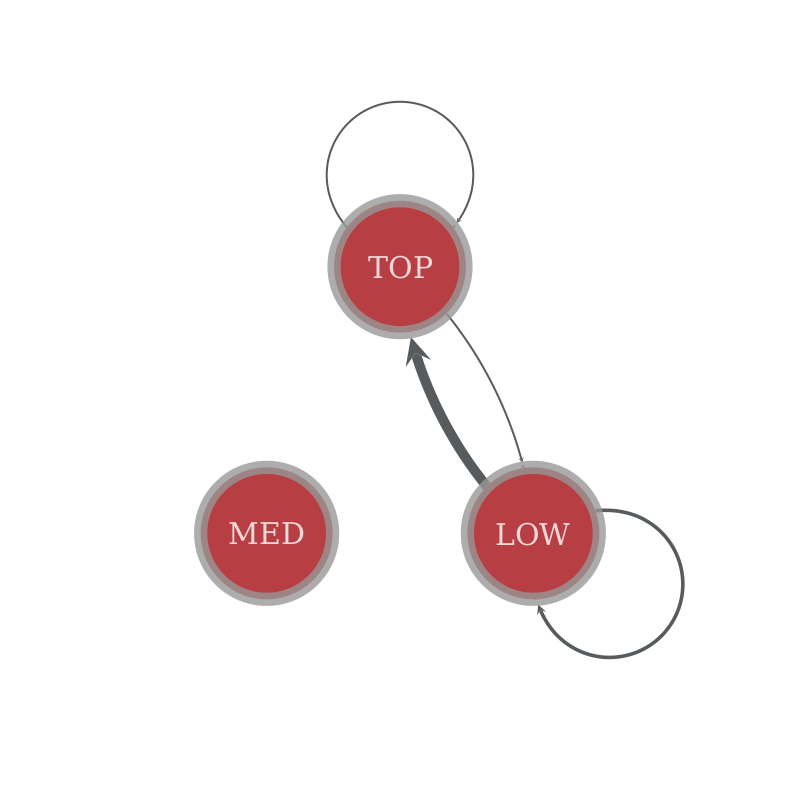

weight edges
draw biased graph


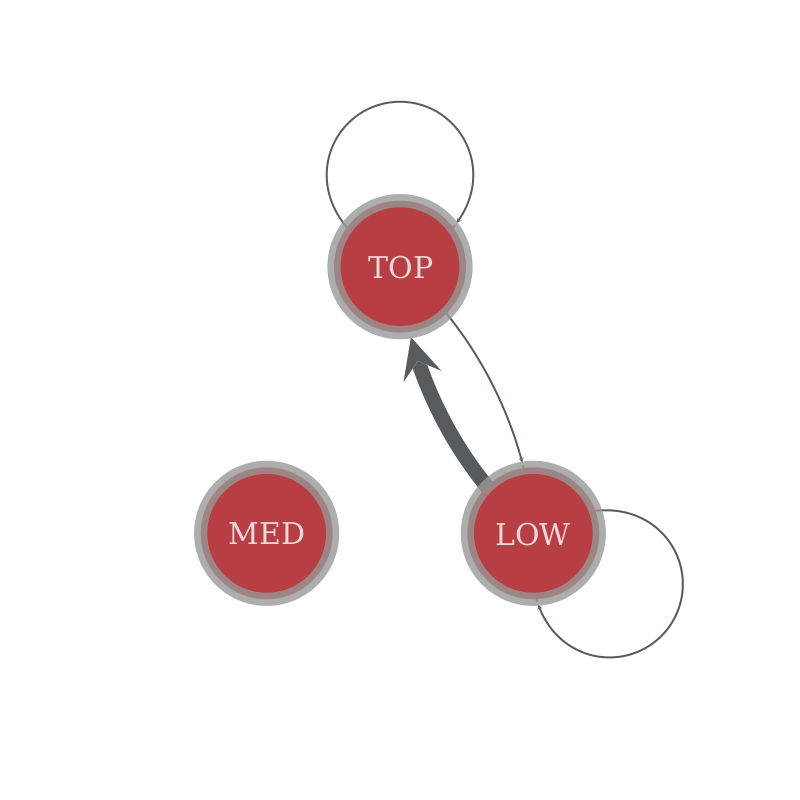

weight edges
draw biased graph


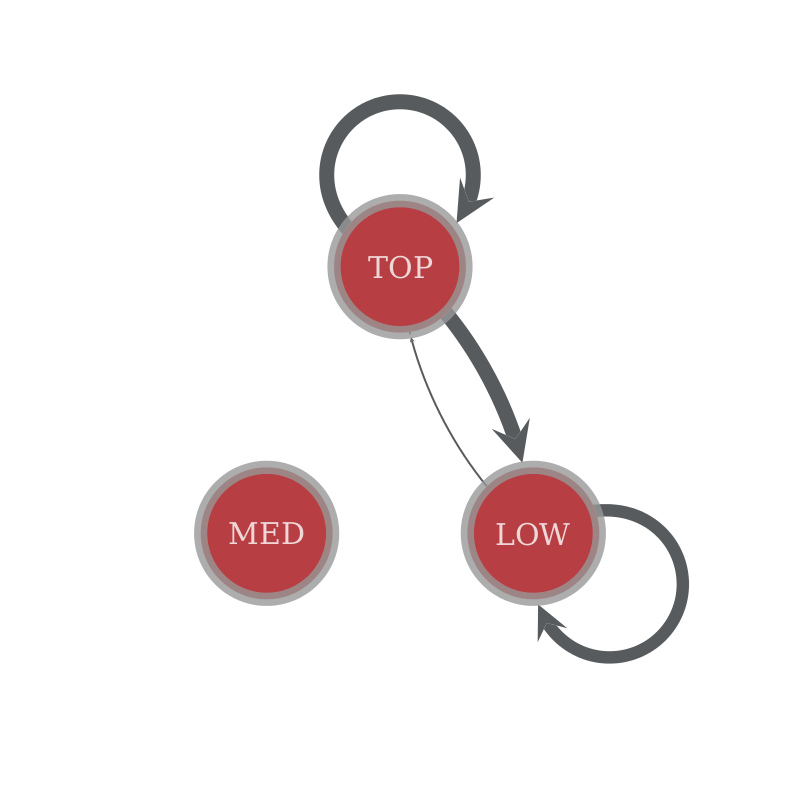

weight edges
draw biased graph


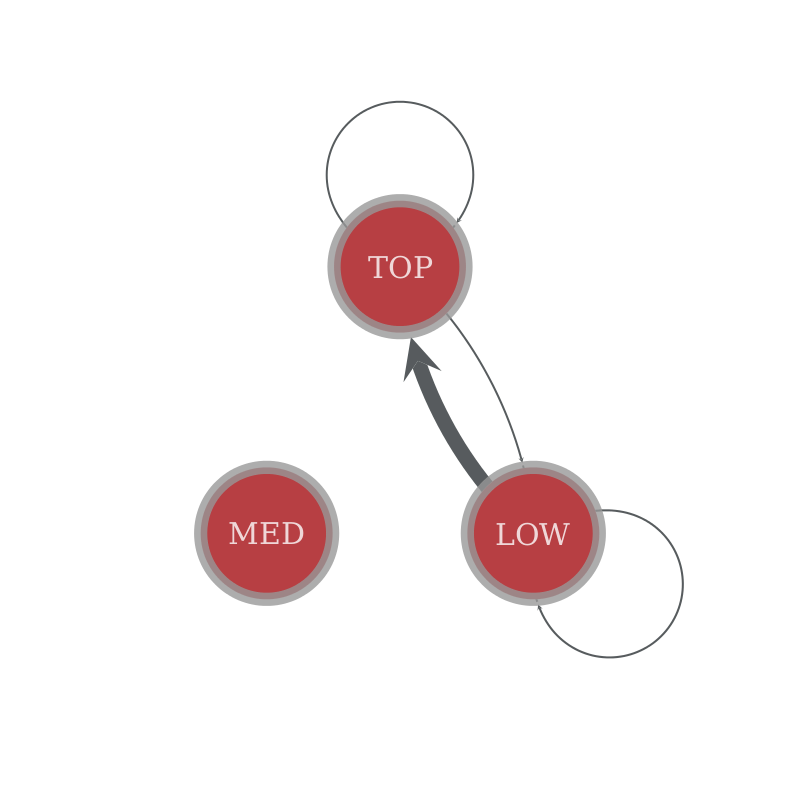

---rewired---
measure: out
max measure: 210182
min measure: 1
TOP limit: 70059
MED limit: 70059
categorize nodes
node dist
TOP 38
MED 0
LOW 70025
urls samples---------
TOP
	 http://mediathek.daserste.de/sendungen-a-z?buchstabe=M
	 http://mediathek.daserste.de
	 http://mediathek.daserste.de/
	 http://mediathek.daserste.de/sendungen-a-z?buchstabe=P
	 http://mediathek.daserste.de/sendungen-a-z?buchstabe=U
	 http://mediathek.daserste.de/sendungen-a-z?buchstabe=F
	 http://mediathek.daserste.de/sendungen-a-z?buchstabe=I
	 http://mediathek.daserste.de/tv/live
	 http://mediathek.daserste.de/sendungVerpasst?tag=2&topRessort
	 http://mediathek.daserste.de/daserste/
LOW
	 http://mediathek.daserste.de/Tagesschau-mit-Gebärdensprache/tagesschau-mit-Gebärdensprache-20-00-Uh/Das-Erste/Video?documentId=18874188&topRessort&bcastId=12722002
	 http://mediathek.daserste.de/Tagesschau/tagesschau-20-00-Uhr/Das-Erste/Video?documentId=10291792&topRessort&bcastId=4326&mpage=page.download
	 http://mediathek.dase

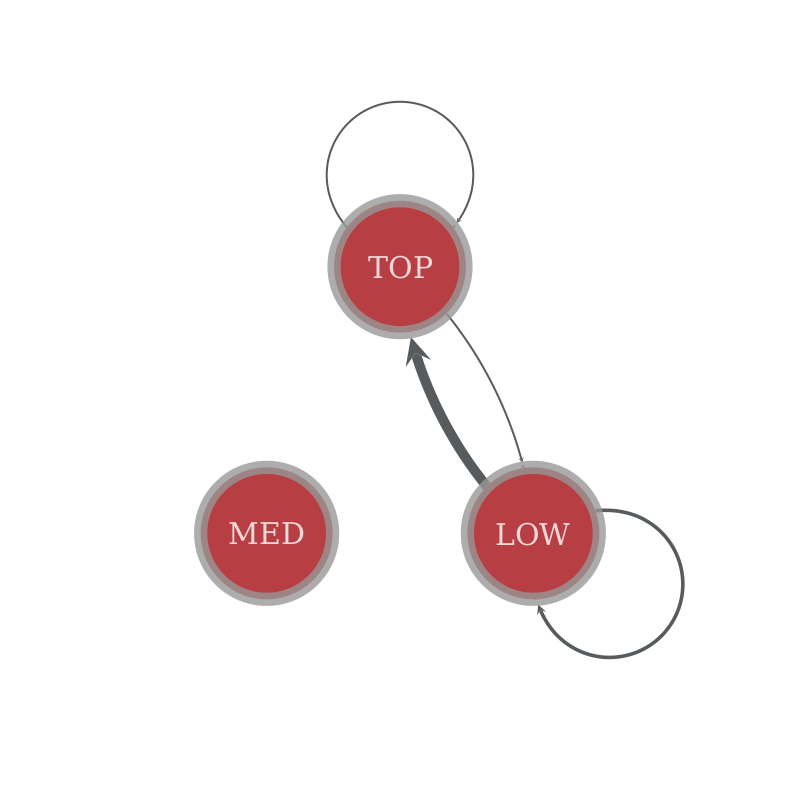

weight edges
draw biased graph


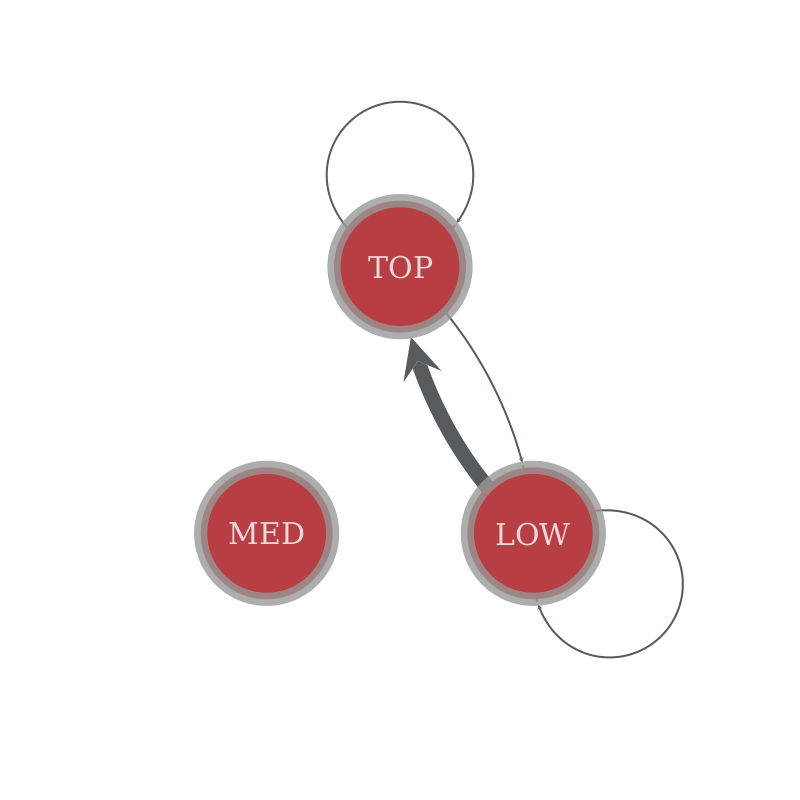

weight edges
draw biased graph


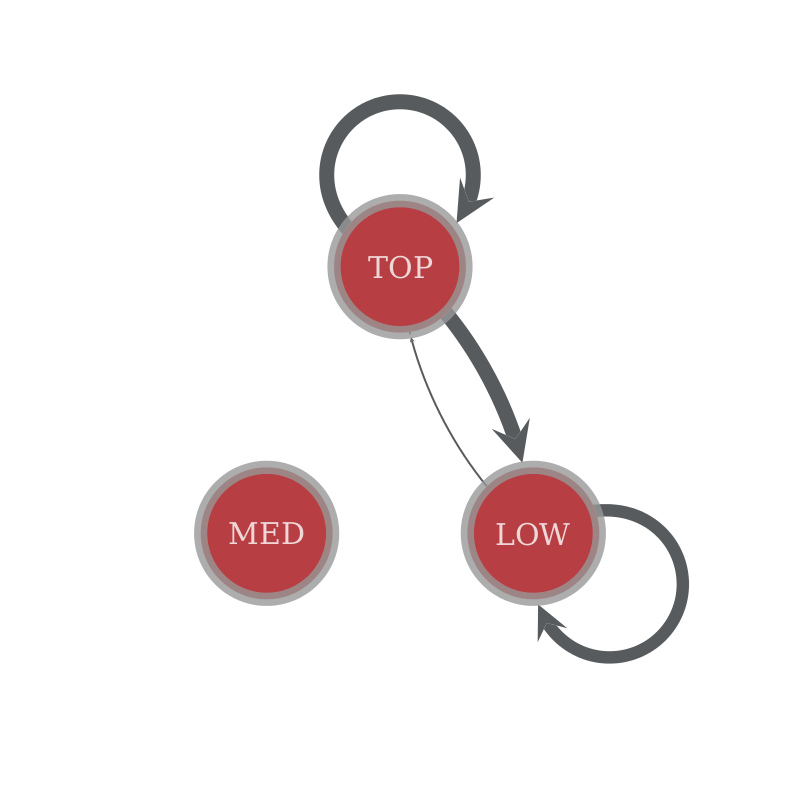

weight edges
draw biased graph


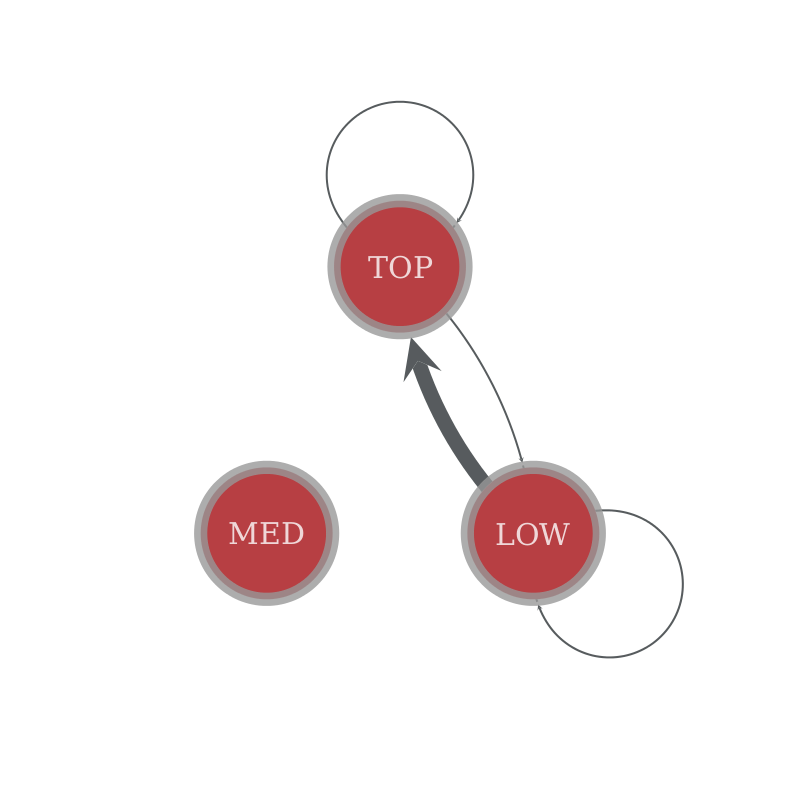

In [5]:
out_dir = 'struct_plots/'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
for ds in datasets:
    cat_measure = 'out'
    network_name = ds['name']
    ds = ds.copy()
    ds.pop("name", None)
    file_name = network_name.rsplit('/', 1)[-1]
    print(file_name.center(80, '='))
    net = get_network(network_name, **ds)
    network_name, file_name = file_name, network_name
    print('\t', network_name, ':', net.num_vertices(), 'v', net.num_edges(), 'e')
    viz_net_struct(net, out_dir + network_name, measure = cat_measure, med_perc=33, high_perc=66)
    random_rewire(net, 'correlated')
    print('---rewired---')
    viz_net_struct(net, out_dir + network_name + '_rw', measure = cat_measure, med_perc=33, high_perc=66)
    # break